In [1]:
import sys
import numpy as np
sys.path.append("..")
from IPython.display import SVG
import keras
from keras.utils.vis_utils import model_to_dot
from models import autoencoderV6
from utils.data_preprocessing import encode_sequences, MinMaxScaler3D, shuffle_array
from utils.parsers import parse_bulkiness, parse_hydrophobicity, parse_csv, load_kabat, aa_order, aa3_aa1
from utils.defines import VL_LENGTH, VH_LENGTH
import os

Using TensorFlow backend.
W0417 09:36:10.887854 140511722092352 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:360: The name name_scope is deprecated. Please use compat.v1.name_scope instead.



In [2]:
class AminoAcidEncoder:
    def __init__(self, max_length, copy=True):
        """
        3D matrix scaling for RNN preparation with mask
        """
        self.copy = copy
        self.aa_order = list(map(lambda x: aa3_aa1[x], aa_order))
        self.max_length = max_length

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        result = np.zeros((len(X), self.max_length, len(aa_order)+1))
        for i in range(len(X)):
            for j in range(len(X[i])):
                try:
                    result[i, j, self.aa_order.index(X[i][j])] = 1
                except:
                    result[i, j, len(aa_order)] = 1
        return result

    def inverse_transform(self, X, y=None):
        result = list()
        for i in range(X.shape[0]):
            result_i=list()
            for j in range(self.max_length):
                idx = np.where(X[i,j]==1)[0]
                if idx.size != 0:
                    idx = int(idx)
                    if idx < len(self.aa_order):
                        result_i.append(self.aa_order[idx])
                    else:
                        result_i.append('')
            print(i, ''.join(result_i))
            result.append(''.join(result_i))
        return result

In [3]:
VL_sequences, VH_sequences, names_mask, animals_mask = \
    parse_csv(VH_LENGTH, VL_LENGTH,
              "../data/abysis_data_201801/abysis_data/emblig-20180125-7578.csv",
              "../data/abysis_data_201801/abysis_data/kabat-20180117-10288.csv")

VH_encoded = AminoAcidEncoder(max_length=VH_LENGTH).transform(VH_sequences)
VL_encoded = AminoAcidEncoder(max_length=VL_LENGTH).transform(VL_sequences)

VH_encoded_shuffled, VL_encoded_shuffled = shuffle_array(VH_encoded, VL_encoded)

In [4]:
encoder, autoencoder, sess = autoencoderV6(21, latent_dim=50)

W0417 09:36:18.932690 140511722092352 deprecation_wrapper.py:76] From ../models/RNN_autoencoder6.py:24: The name ConfigProto is deprecated. Please use compat.v1.ConfigProto instead.

W0417 09:36:18.933428 140511722092352 deprecation_wrapper.py:76] From ../models/RNN_autoencoder6.py:25: The name Session is deprecated. Please use compat.v1.Session instead.

W0417 09:36:19.683963 140511722092352 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name placeholder is deprecated. Please use compat.v1.placeholder instead.

W0417 09:36:22.498849 140511722092352 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name random_uniform is deprecated. Please use random.uniform instead.

W0417 09:36:22.800615 140511722092352 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name train.Optimizer i

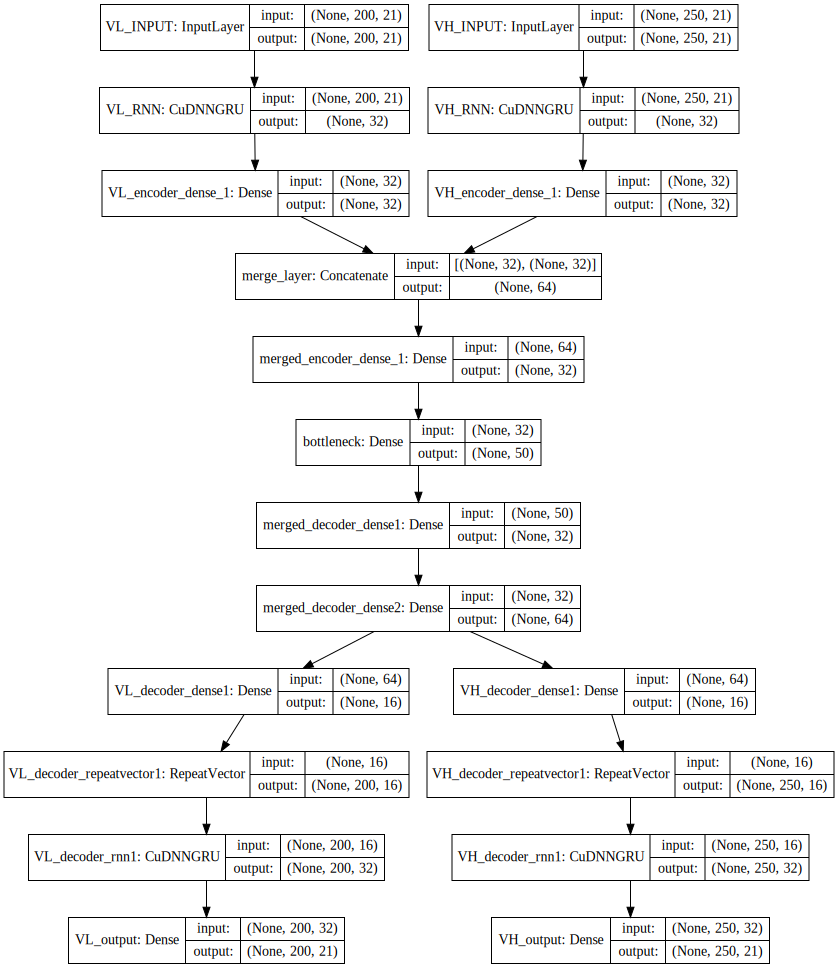

In [5]:
SVG(model_to_dot(autoencoder, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
NAME= 'autoencoderV6_raw'
RUN = 'run2'

weight_path = '../model_weights/{}/{}/{}.hdf5'.format(NAME,RUN,NAME)
log_path = '../logs/{}/{}'.format(NAME, RUN)

In [7]:
if not os.path.exists('../model_weights/{}/{}/'.format(NAME,RUN)):
    if not os.path.exists('../model_weights/{}'.format(NAME)):
        os.mkdir('../model_weights/{}'.format(NAME))
    os.mkdir('../model_weights/{}/{}'.format(NAME,RUN))

In [8]:
from keras import backend as K

In [9]:
def get_loss(mask_value):

    """

    :param mask_value:
    :return:
    """

    mask_value = K.variable(mask_value, dtype=K.floatx())

    def masked_entropy(y_true, y_pred):
        # find out which timesteps in `y_true` are not the padding character
        mask = K.all(K.equal(y_true, mask_value), axis=-1)
        mask = 1 - K.cast(mask, K.floatx())
        mask_sum = K.sum(mask)
        l=K.tf.contrib.seq2seq.sequence_loss(targets=K.argmax(y_true), logits=y_pred, weights=mask,
                                     average_across_batch=False, average_across_timesteps=False)
        return K.sum(l) / mask_sum
    return masked_entropy
    
lhs=K.placeholder((None,200,21))
rhs=K.placeholder((None,200,21))

func=get_loss(0)(lhs, rhs)
r=K.get_session().run(func, feed_dict={lhs: VL_encoded_shuffled[:1], rhs: VL_encoded_shuffled[:1]})

In [10]:
# lhs=K.placeholder((None,None, 2))
# rhs=K.placeholder((None, 2), dtype=K.tf.int32)
# mask = K.all(K.equal(rhs,  K.constant(0, dtype=K.tf.int32)), axis=-1)
# mask = K.transpose(K.reshape(K.tile(1 - K.cast(mask, K.floatx()),2), [2,-1]))
# l=K.tf.contrib.seq2seq.sequence_loss(targets=rhs, logits=lhs, weights=mask,
#                                      average_across_batch=False, average_across_timesteps=False)
# # VL_encoded_shuffled[:1][VL_encoded_shuffled[:1]==0.99]=1
# # VL_encoded_shuffled[:1][VL_encoded_shuffled[:1]==0.001]=0
# # a=np.expand_dims(np.array(VL_encoded_shuffled[0]),axis=0)
# # a[a[:1]==1]=0.99
# # a[a[:1]==0]=0.0001
# # K.get_session().run(l, feed_dict={lhs: VL_encoded_shuffled[:1], rhs: a})
# K.get_session().run(l, feed_dict={lhs: np.array([[[0, 9999],[9999, 0]], 
#                                                  [[0, 9999],[9999, 0]],
#                                                  [[0, 9999],[9999, 0]]]), 
#                                   rhs: np.array([[1, 0], [1, 0], [0, 0]])})

In [11]:
def acc(y_true, y_pred):
    mask = K.all(K.equal(y_true, 0), axis=-1)
    mask = 1 - K.cast(mask, K.floatx())
    mask_sum = K.sum(mask)
    acc = K.cast(K.equal(K.argmax(y_true), K.argmax(K.softmax(y_pred))), dtype=K.floatx()) * mask
    return K.sum(acc) / mask_sum

In [12]:
K.get_session().run(acc(VL_encoded_shuffled[:1], VL_encoded_shuffled[:1]))

1.0

In [13]:
autoencoder.compile(optimizer=keras.optimizers.Adamax(), loss=get_loss(0), metrics=[acc])

In [14]:
class CosineAnnealingAdaptiveLRScheduler(keras.callbacks.Callback):

    """
    Keras adaptive learning scheduler implementation of cosine annealing
    that resets every cycle. A cycle unit is defined as the number of
    batches per epoch. The cycle can then be adjusted by a scalar after
    each cycle ending
    """

    def __init__(self, lr=None, cycle_len=1, cycle_mult=2):

        """
        CosineAnnealingAdaptiveLRScheduler constructor.
        Args:
            lr: base learning rate. If set to None it will be inferred from the model optimiser.
            cycle_len: initial cycle length. If set to 1 it will be equivalent to the number of batches per epoch
            cycle_mult: scalar to adjust cycle length at the end of each epoch
        """

        super(CosineAnnealingAdaptiveLRScheduler, self).__init__()

        self.lr = lr
        self.cycle_len = cycle_len
        self.cycle_mult = cycle_mult
        self.iteration = 0
        self.steps_per_epoch = None
        self.current_cycle_iterations = None

    def on_batch_begin(self, epoch, logs=None):

        """
        Callback to adjust the learning rate at the start of each batch
        Args:
            epoch:
            logs:
        Returns:
        """

        if self.current_cycle_iterations < self.iteration:
            # update cycle length
            self.cycle_len *= self.cycle_mult
            self.current_cycle_iterations = self._get_iter_per_cycle()
            # reset state to start new cycle
            self._reset()

        # cosine annealing -> the self.current_cycle_iterations+1 avoids cos(pi) which is 0
        new_lr = (np.cos(self.iteration / (self.current_cycle_iterations + 1) * np.pi) + 1) * self.lr

        K.set_value(self.model.optimizer.lr, new_lr)

#         print('\nIteration {}/{}: {}\n'.format(self.iteration, self.current_cycle_iterations, new_lr))

        self.iteration += 1

    def _get_iter_per_cycle(self):
        """
        Calculate the number of iterations in current cycle
        Returns:
        """
        return self.steps_per_epoch * self.cycle_len

    # adapted from https://github.com/uber/horovod/blob/master/horovod/keras/callbacks.py
    def on_train_begin(self, logs=None):
        """
        Sets some attributes that can only be inferred at model runtime.
        Args:
            logs:
        Returns:
        """
        if self.lr is None:
            self.lr = K.get_value(self.model.optimizer.lr)
        self.steps_per_epoch = self._autodetect_steps_per_epoch()
        self.current_cycle_iterations = self.steps_per_epoch * self.cycle_len

        # compensates for cosine annealing -> could divide by 2 at each step, or just do it here
        self.lr /= 2

    # https://github.com/uber/horovod/blob/master/horovod/keras/callbacks.py
    def _autodetect_steps_per_epoch(self):
        """
        Determine the number of steps per epoch.
        Returns:
        """
        if self.params.get('steps'):
            # The number of steps is provided in the parameters.
            return self.params['steps']
        elif self.params.get('samples') and self.params.get('batch_size'):
            # Compute the number of steps per epoch using # of samples and a batch size.
            return self.params['samples'] // self.params['batch_size']
        else:
            raise ValueError('Could not autodetect the number of steps per epoch. '
                             'Please specify the steps_per_epoch parameter to the '
                             '%s() or upgrade to the latest version of Keras.'
                             % self.__class__.__name__)

    def _reset(self):
        """
        Reset the state of the learning rate to start a new cycle.
        Returns:
        """
        self.iteration = 0

In [15]:
history = autoencoder.fit([VL_encoded_shuffled, VH_encoded_shuffled], [VL_encoded_shuffled, VH_encoded_shuffled],
                          epochs=5000, batch_size=32, validation_split=0.2,
                          callbacks=[CosineAnnealingAdaptiveLRScheduler(lr=0.01, cycle_len=2, cycle_mult=2),
                                     keras.callbacks.ModelCheckpoint(weight_path, save_best_only=True),
                                     keras.callbacks.TensorBoard(log_path)])

Train on 4144 samples, validate on 1036 samples


W0417 09:36:24.970722 140511722092352 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:850: The name summary.merge_all is deprecated. Please use compat.v1.summary.merge_all instead.

W0417 09:36:24.971192 140511722092352 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:853: The name summary.FileWriter is deprecated. Please use compat.v1.summary.FileWriter instead.



Epoch 1/5000
4144/4144 [==============================] - 10s 2ms/step - loss: 5.6119 - VL_output_loss: 2.7917 - VH_output_loss: 2.8202 - VL_output_acc: 0.1510 - VH_output_acc: 0.1274 - val_loss: 5.5253 - val_VL_output_loss: 2.7502 - val_VH_output_loss: 2.7751 - val_VL_output_acc: 0.1486 - val_VH_output_acc: 0.1360
Epoch 2/5000
4144/4144 [==============================] - 3s 692us/step - loss: 5.5073 - VL_output_loss: 2.7412 - VH_output_loss: 2.7661 - VL_output_acc: 0.1520 - VH_output_acc: 0.1378 - val_loss: 5.5042 - val_VL_output_loss: 2.7382 - val_VH_output_loss: 2.7660 - val_VL_output_acc: 0.1472 - val_VH_output_acc: 0.1431
Epoch 3/5000
4144/4144 [==============================] - 3s 710us/step - loss: 5.4444 - VL_output_loss: 2.6998 - VH_output_loss: 2.7446 - VL_output_acc: 0.1687 - VH_output_acc: 0.1435 - val_loss: 5.3971 - val_VL_output_loss: 2.6681 - val_VH_output_loss: 2.7290 - val_VL_output_acc: 0.1753 - val_VH_output_acc: 0.1435
Epoch 4/5000
4144/4144 [=======================

Epoch 27/5000
4144/4144 [==============================] - 3s 748us/step - loss: 4.9871 - VL_output_loss: 2.4880 - VH_output_loss: 2.4991 - VL_output_acc: 0.2275 - VH_output_acc: 0.2269 - val_loss: 4.9985 - val_VL_output_loss: 2.4951 - val_VH_output_loss: 2.5034 - val_VL_output_acc: 0.2241 - val_VH_output_acc: 0.2266
Epoch 28/5000
4144/4144 [==============================] - 3s 755us/step - loss: 4.9848 - VL_output_loss: 2.4870 - VH_output_loss: 2.4977 - VL_output_acc: 0.2277 - VH_output_acc: 0.2274 - val_loss: 4.9934 - val_VL_output_loss: 2.4943 - val_VH_output_loss: 2.4991 - val_VL_output_acc: 0.2230 - val_VH_output_acc: 0.2257
Epoch 29/5000
4144/4144 [==============================] - 3s 749us/step - loss: 4.9818 - VL_output_loss: 2.4857 - VH_output_loss: 2.4961 - VL_output_acc: 0.2283 - VH_output_acc: 0.2287 - val_loss: 4.9939 - val_VL_output_loss: 2.4947 - val_VH_output_loss: 2.4992 - val_VL_output_acc: 0.2270 - val_VH_output_acc: 0.2291
Epoch 30/5000
4144/4144 [==================

Epoch 53/5000
4144/4144 [==============================] - 3s 749us/step - loss: 4.8478 - VL_output_loss: 2.4270 - VH_output_loss: 2.4208 - VL_output_acc: 0.2556 - VH_output_acc: 0.2903 - val_loss: 4.8712 - val_VL_output_loss: 2.4399 - val_VH_output_loss: 2.4313 - val_VL_output_acc: 0.2496 - val_VH_output_acc: 0.2874
Epoch 54/5000
4144/4144 [==============================] - 3s 744us/step - loss: 4.8482 - VL_output_loss: 2.4276 - VH_output_loss: 2.4206 - VL_output_acc: 0.2548 - VH_output_acc: 0.2887 - val_loss: 4.8632 - val_VL_output_loss: 2.4406 - val_VH_output_loss: 2.4226 - val_VL_output_acc: 0.2483 - val_VH_output_acc: 0.2962
Epoch 55/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.8445 - VL_output_loss: 2.4258 - VH_output_loss: 2.4186 - VL_output_acc: 0.2555 - VH_output_acc: 0.2923 - val_loss: 4.8652 - val_VL_output_loss: 2.4384 - val_VH_output_loss: 2.4268 - val_VL_output_acc: 0.2483 - val_VH_output_acc: 0.2876
Epoch 56/5000
4144/4144 [==================

Epoch 79/5000
4144/4144 [==============================] - 3s 746us/step - loss: 4.7933 - VL_output_loss: 2.3985 - VH_output_loss: 2.3948 - VL_output_acc: 0.2656 - VH_output_acc: 0.2981 - val_loss: 4.8074 - val_VL_output_loss: 2.4084 - val_VH_output_loss: 2.3990 - val_VL_output_acc: 0.2622 - val_VH_output_acc: 0.3016
Epoch 80/5000
4144/4144 [==============================] - 3s 759us/step - loss: 4.7910 - VL_output_loss: 2.3988 - VH_output_loss: 2.3922 - VL_output_acc: 0.2658 - VH_output_acc: 0.3007 - val_loss: 4.8037 - val_VL_output_loss: 2.4119 - val_VH_output_loss: 2.3918 - val_VL_output_acc: 0.2606 - val_VH_output_acc: 0.3011
Epoch 81/5000
4144/4144 [==============================] - 3s 744us/step - loss: 4.7881 - VL_output_loss: 2.3923 - VH_output_loss: 2.3958 - VL_output_acc: 0.2694 - VH_output_acc: 0.2971 - val_loss: 4.8168 - val_VL_output_loss: 2.4077 - val_VH_output_loss: 2.4091 - val_VL_output_acc: 0.2612 - val_VH_output_acc: 0.2945
Epoch 82/5000
4144/4144 [==================

Epoch 105/5000
4144/4144 [==============================] - 3s 748us/step - loss: 4.7414 - VL_output_loss: 2.3743 - VH_output_loss: 2.3670 - VL_output_acc: 0.2785 - VH_output_acc: 0.3087 - val_loss: 4.7628 - val_VL_output_loss: 2.3930 - val_VH_output_loss: 2.3698 - val_VL_output_acc: 0.2692 - val_VH_output_acc: 0.3119
Epoch 106/5000
4144/4144 [==============================] - 3s 745us/step - loss: 4.7381 - VL_output_loss: 2.3720 - VH_output_loss: 2.3660 - VL_output_acc: 0.2790 - VH_output_acc: 0.3100 - val_loss: 4.7624 - val_VL_output_loss: 2.3928 - val_VH_output_loss: 2.3695 - val_VL_output_acc: 0.2694 - val_VH_output_acc: 0.3109
Epoch 107/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.7376 - VL_output_loss: 2.3719 - VH_output_loss: 2.3657 - VL_output_acc: 0.2787 - VH_output_acc: 0.3099 - val_loss: 4.7623 - val_VL_output_loss: 2.3927 - val_VH_output_loss: 2.3696 - val_VL_output_acc: 0.2699 - val_VH_output_acc: 0.3108
Epoch 108/5000
4144/4144 [==============

Epoch 131/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.7612 - VL_output_loss: 2.3725 - VH_output_loss: 2.3887 - VL_output_acc: 0.2777 - VH_output_acc: 0.2955 - val_loss: 4.7937 - val_VL_output_loss: 2.3916 - val_VH_output_loss: 2.4022 - val_VL_output_acc: 0.2709 - val_VH_output_acc: 0.2867
Epoch 132/5000
4144/4144 [==============================] - 3s 740us/step - loss: 4.7394 - VL_output_loss: 2.3717 - VH_output_loss: 2.3676 - VL_output_acc: 0.2789 - VH_output_acc: 0.3093 - val_loss: 4.7593 - val_VL_output_loss: 2.3925 - val_VH_output_loss: 2.3668 - val_VL_output_acc: 0.2663 - val_VH_output_acc: 0.3133
Epoch 133/5000
4144/4144 [==============================] - 3s 733us/step - loss: 4.7431 - VL_output_loss: 2.3788 - VH_output_loss: 2.3643 - VL_output_acc: 0.2746 - VH_output_acc: 0.3106 - val_loss: 4.7644 - val_VL_output_loss: 2.3906 - val_VH_output_loss: 2.3739 - val_VL_output_acc: 0.2682 - val_VH_output_acc: 0.3041
Epoch 134/5000
4144/4144 [==============

Epoch 157/5000
4144/4144 [==============================] - 3s 740us/step - loss: 4.7090 - VL_output_loss: 2.3634 - VH_output_loss: 2.3457 - VL_output_acc: 0.2824 - VH_output_acc: 0.3158 - val_loss: 4.7331 - val_VL_output_loss: 2.3837 - val_VH_output_loss: 2.3494 - val_VL_output_acc: 0.2729 - val_VH_output_acc: 0.3148
Epoch 158/5000
4144/4144 [==============================] - 3s 734us/step - loss: 4.7101 - VL_output_loss: 2.3635 - VH_output_loss: 2.3467 - VL_output_acc: 0.2822 - VH_output_acc: 0.3155 - val_loss: 4.7355 - val_VL_output_loss: 2.3867 - val_VH_output_loss: 2.3489 - val_VL_output_acc: 0.2655 - val_VH_output_acc: 0.3163
Epoch 159/5000
4144/4144 [==============================] - 3s 730us/step - loss: 4.7069 - VL_output_loss: 2.3617 - VH_output_loss: 2.3453 - VL_output_acc: 0.2822 - VH_output_acc: 0.3155 - val_loss: 4.7341 - val_VL_output_loss: 2.3850 - val_VH_output_loss: 2.3491 - val_VL_output_acc: 0.2719 - val_VH_output_acc: 0.3156
Epoch 160/5000
4144/4144 [==============

Epoch 183/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.6912 - VL_output_loss: 2.3547 - VH_output_loss: 2.3366 - VL_output_acc: 0.2866 - VH_output_acc: 0.3192 - val_loss: 4.7168 - val_VL_output_loss: 2.3781 - val_VH_output_loss: 2.3387 - val_VL_output_acc: 0.2761 - val_VH_output_acc: 0.3222
Epoch 184/5000
4144/4144 [==============================] - 3s 727us/step - loss: 4.6905 - VL_output_loss: 2.3548 - VH_output_loss: 2.3357 - VL_output_acc: 0.2864 - VH_output_acc: 0.3197 - val_loss: 4.7169 - val_VL_output_loss: 2.3772 - val_VH_output_loss: 2.3397 - val_VL_output_acc: 0.2756 - val_VH_output_acc: 0.3168
Epoch 185/5000
4144/4144 [==============================] - 3s 745us/step - loss: 4.6903 - VL_output_loss: 2.3547 - VH_output_loss: 2.3356 - VL_output_acc: 0.2864 - VH_output_acc: 0.3193 - val_loss: 4.7153 - val_VL_output_loss: 2.3768 - val_VH_output_loss: 2.3385 - val_VL_output_acc: 0.2752 - val_VH_output_acc: 0.3227
Epoch 186/5000
4144/4144 [==============

Epoch 209/5000
4144/4144 [==============================] - 3s 724us/step - loss: 4.6804 - VL_output_loss: 2.3514 - VH_output_loss: 2.3290 - VL_output_acc: 0.2878 - VH_output_acc: 0.3235 - val_loss: 4.7075 - val_VL_output_loss: 2.3743 - val_VH_output_loss: 2.3332 - val_VL_output_acc: 0.2770 - val_VH_output_acc: 0.3234
Epoch 210/5000
4144/4144 [==============================] - 3s 747us/step - loss: 4.6799 - VL_output_loss: 2.3508 - VH_output_loss: 2.3291 - VL_output_acc: 0.2880 - VH_output_acc: 0.3232 - val_loss: 4.7071 - val_VL_output_loss: 2.3743 - val_VH_output_loss: 2.3329 - val_VL_output_acc: 0.2767 - val_VH_output_acc: 0.3222
Epoch 211/5000
4144/4144 [==============================] - 3s 730us/step - loss: 4.6804 - VL_output_loss: 2.3516 - VH_output_loss: 2.3288 - VL_output_acc: 0.2874 - VH_output_acc: 0.3226 - val_loss: 4.7071 - val_VL_output_loss: 2.3748 - val_VH_output_loss: 2.3323 - val_VL_output_acc: 0.2768 - val_VH_output_acc: 0.3208
Epoch 212/5000
4144/4144 [==============

Epoch 235/5000
4144/4144 [==============================] - 3s 756us/step - loss: 4.6729 - VL_output_loss: 2.3494 - VH_output_loss: 2.3235 - VL_output_acc: 0.2883 - VH_output_acc: 0.3260 - val_loss: 4.7011 - val_VL_output_loss: 2.3731 - val_VH_output_loss: 2.3279 - val_VL_output_acc: 0.2774 - val_VH_output_acc: 0.3272
Epoch 236/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.6730 - VL_output_loss: 2.3498 - VH_output_loss: 2.3233 - VL_output_acc: 0.2883 - VH_output_acc: 0.3263 - val_loss: 4.7021 - val_VL_output_loss: 2.3730 - val_VH_output_loss: 2.3290 - val_VL_output_acc: 0.2774 - val_VH_output_acc: 0.3246
Epoch 237/5000
4144/4144 [==============================] - 3s 757us/step - loss: 4.6726 - VL_output_loss: 2.3493 - VH_output_loss: 2.3233 - VL_output_acc: 0.2886 - VH_output_acc: 0.3257 - val_loss: 4.7008 - val_VL_output_loss: 2.3732 - val_VH_output_loss: 2.3276 - val_VL_output_acc: 0.2774 - val_VH_output_acc: 0.3271
Epoch 238/5000
4144/4144 [==============

Epoch 261/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.6737 - VL_output_loss: 2.3497 - VH_output_loss: 2.3240 - VL_output_acc: 0.2868 - VH_output_acc: 0.3257 - val_loss: 4.7060 - val_VL_output_loss: 2.3760 - val_VH_output_loss: 2.3300 - val_VL_output_acc: 0.2749 - val_VH_output_acc: 0.3240
Epoch 262/5000
4144/4144 [==============================] - 3s 739us/step - loss: 4.6761 - VL_output_loss: 2.3521 - VH_output_loss: 2.3240 - VL_output_acc: 0.2858 - VH_output_acc: 0.3246 - val_loss: 4.7011 - val_VL_output_loss: 2.3735 - val_VH_output_loss: 2.3276 - val_VL_output_acc: 0.2766 - val_VH_output_acc: 0.3264
Epoch 263/5000
4144/4144 [==============================] - 3s 739us/step - loss: 4.6765 - VL_output_loss: 2.3532 - VH_output_loss: 2.3234 - VL_output_acc: 0.2857 - VH_output_acc: 0.3254 - val_loss: 4.7017 - val_VL_output_loss: 2.3748 - val_VH_output_loss: 2.3269 - val_VL_output_acc: 0.2762 - val_VH_output_acc: 0.3235
Epoch 264/5000
4144/4144 [==============

Epoch 287/5000
4144/4144 [==============================] - 3s 748us/step - loss: 4.7515 - VL_output_loss: 2.3475 - VH_output_loss: 2.4040 - VL_output_acc: 0.2876 - VH_output_acc: 0.2988 - val_loss: 4.7723 - val_VL_output_loss: 2.3694 - val_VH_output_loss: 2.4029 - val_VL_output_acc: 0.2763 - val_VH_output_acc: 0.2963
Epoch 288/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.7419 - VL_output_loss: 2.3467 - VH_output_loss: 2.3953 - VL_output_acc: 0.2878 - VH_output_acc: 0.3012 - val_loss: 4.7665 - val_VL_output_loss: 2.3718 - val_VH_output_loss: 2.3947 - val_VL_output_acc: 0.2773 - val_VH_output_acc: 0.3013
Epoch 289/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.7358 - VL_output_loss: 2.3470 - VH_output_loss: 2.3888 - VL_output_acc: 0.2879 - VH_output_acc: 0.3070 - val_loss: 4.7588 - val_VL_output_loss: 2.3699 - val_VH_output_loss: 2.3889 - val_VL_output_acc: 0.2772 - val_VH_output_acc: 0.3111
Epoch 290/5000
4144/4144 [==============

Epoch 313/5000
4144/4144 [==============================] - 3s 733us/step - loss: 4.7024 - VL_output_loss: 2.3442 - VH_output_loss: 2.3582 - VL_output_acc: 0.2881 - VH_output_acc: 0.3147 - val_loss: 4.7254 - val_VL_output_loss: 2.3679 - val_VH_output_loss: 2.3575 - val_VL_output_acc: 0.2767 - val_VH_output_acc: 0.3116
Epoch 314/5000
4144/4144 [==============================] - 3s 730us/step - loss: 4.7373 - VL_output_loss: 2.3444 - VH_output_loss: 2.3929 - VL_output_acc: 0.2880 - VH_output_acc: 0.2956 - val_loss: 4.7372 - val_VL_output_loss: 2.3679 - val_VH_output_loss: 2.3694 - val_VL_output_acc: 0.2771 - val_VH_output_acc: 0.3078
Epoch 315/5000
4144/4144 [==============================] - 3s 734us/step - loss: 4.7048 - VL_output_loss: 2.3438 - VH_output_loss: 2.3610 - VL_output_acc: 0.2885 - VH_output_acc: 0.3110 - val_loss: 4.7280 - val_VL_output_loss: 2.3686 - val_VH_output_loss: 2.3593 - val_VL_output_acc: 0.2767 - val_VH_output_acc: 0.3119
Epoch 316/5000
4144/4144 [==============

Epoch 339/5000
4144/4144 [==============================] - 3s 732us/step - loss: 4.6847 - VL_output_loss: 2.3428 - VH_output_loss: 2.3419 - VL_output_acc: 0.2887 - VH_output_acc: 0.3197 - val_loss: 4.7145 - val_VL_output_loss: 2.3661 - val_VH_output_loss: 2.3485 - val_VL_output_acc: 0.2768 - val_VH_output_acc: 0.3109
Epoch 340/5000
4144/4144 [==============================] - 3s 731us/step - loss: 4.6825 - VL_output_loss: 2.3425 - VH_output_loss: 2.3401 - VL_output_acc: 0.2886 - VH_output_acc: 0.3211 - val_loss: 4.7079 - val_VL_output_loss: 2.3664 - val_VH_output_loss: 2.3415 - val_VL_output_acc: 0.2787 - val_VH_output_acc: 0.3207
Epoch 341/5000
4144/4144 [==============================] - 3s 725us/step - loss: 4.6813 - VL_output_loss: 2.3428 - VH_output_loss: 2.3385 - VL_output_acc: 0.2885 - VH_output_acc: 0.3215 - val_loss: 4.7138 - val_VL_output_loss: 2.3692 - val_VH_output_loss: 2.3445 - val_VL_output_acc: 0.2777 - val_VH_output_acc: 0.3205
Epoch 342/5000
4144/4144 [==============

Epoch 365/5000
4144/4144 [==============================] - 3s 726us/step - loss: 4.6567 - VL_output_loss: 2.3387 - VH_output_loss: 2.3180 - VL_output_acc: 0.2899 - VH_output_acc: 0.3276 - val_loss: 4.6858 - val_VL_output_loss: 2.3656 - val_VH_output_loss: 2.3202 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.3274
Epoch 366/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.6578 - VL_output_loss: 2.3393 - VH_output_loss: 2.3185 - VL_output_acc: 0.2894 - VH_output_acc: 0.3278 - val_loss: 4.6835 - val_VL_output_loss: 2.3646 - val_VH_output_loss: 2.3189 - val_VL_output_acc: 0.2797 - val_VH_output_acc: 0.3282
Epoch 367/5000
4144/4144 [==============================] - 3s 732us/step - loss: 4.6558 - VL_output_loss: 2.3389 - VH_output_loss: 2.3170 - VL_output_acc: 0.2897 - VH_output_acc: 0.3280 - val_loss: 4.6840 - val_VL_output_loss: 2.3639 - val_VH_output_loss: 2.3201 - val_VL_output_acc: 0.2778 - val_VH_output_acc: 0.3281
Epoch 368/5000
4144/4144 [==============

Epoch 391/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.6450 - VL_output_loss: 2.3389 - VH_output_loss: 2.3061 - VL_output_acc: 0.2897 - VH_output_acc: 0.3290 - val_loss: 4.6739 - val_VL_output_loss: 2.3643 - val_VH_output_loss: 2.3096 - val_VL_output_acc: 0.2774 - val_VH_output_acc: 0.3286
Epoch 392/5000
4144/4144 [==============================] - 3s 726us/step - loss: 4.6448 - VL_output_loss: 2.3386 - VH_output_loss: 2.3062 - VL_output_acc: 0.2901 - VH_output_acc: 0.3292 - val_loss: 4.6741 - val_VL_output_loss: 2.3648 - val_VH_output_loss: 2.3093 - val_VL_output_acc: 0.2785 - val_VH_output_acc: 0.3285
Epoch 393/5000
4144/4144 [==============================] - 3s 733us/step - loss: 4.6508 - VL_output_loss: 2.3442 - VH_output_loss: 2.3066 - VL_output_acc: 0.2859 - VH_output_acc: 0.3287 - val_loss: 4.6715 - val_VL_output_loss: 2.3629 - val_VH_output_loss: 2.3086 - val_VL_output_acc: 0.2791 - val_VH_output_acc: 0.3300
Epoch 394/5000
4144/4144 [==============

Epoch 417/5000
4144/4144 [==============================] - 3s 733us/step - loss: 4.6403 - VL_output_loss: 2.3365 - VH_output_loss: 2.3039 - VL_output_acc: 0.2905 - VH_output_acc: 0.3294 - val_loss: 4.6688 - val_VL_output_loss: 2.3618 - val_VH_output_loss: 2.3070 - val_VL_output_acc: 0.2788 - val_VH_output_acc: 0.3301
Epoch 418/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.6408 - VL_output_loss: 2.3366 - VH_output_loss: 2.3043 - VL_output_acc: 0.2902 - VH_output_acc: 0.3291 - val_loss: 4.6697 - val_VL_output_loss: 2.3622 - val_VH_output_loss: 2.3074 - val_VL_output_acc: 0.2768 - val_VH_output_acc: 0.3281
Epoch 419/5000
4144/4144 [==============================] - 3s 744us/step - loss: 4.6401 - VL_output_loss: 2.3360 - VH_output_loss: 2.3041 - VL_output_acc: 0.2906 - VH_output_acc: 0.3296 - val_loss: 4.6719 - val_VL_output_loss: 2.3652 - val_VH_output_loss: 2.3066 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.3286
Epoch 420/5000
4144/4144 [==============

Epoch 443/5000
4144/4144 [==============================] - 3s 730us/step - loss: 4.6350 - VL_output_loss: 2.3336 - VH_output_loss: 2.3014 - VL_output_acc: 0.2911 - VH_output_acc: 0.3297 - val_loss: 4.6644 - val_VL_output_loss: 2.3603 - val_VH_output_loss: 2.3041 - val_VL_output_acc: 0.2791 - val_VH_output_acc: 0.3296
Epoch 444/5000
4144/4144 [==============================] - 3s 737us/step - loss: 4.6345 - VL_output_loss: 2.3335 - VH_output_loss: 2.3010 - VL_output_acc: 0.2908 - VH_output_acc: 0.3297 - val_loss: 4.6643 - val_VL_output_loss: 2.3606 - val_VH_output_loss: 2.3038 - val_VL_output_acc: 0.2799 - val_VH_output_acc: 0.3286
Epoch 445/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.6342 - VL_output_loss: 2.3337 - VH_output_loss: 2.3006 - VL_output_acc: 0.2909 - VH_output_acc: 0.3297 - val_loss: 4.6643 - val_VL_output_loss: 2.3602 - val_VH_output_loss: 2.3040 - val_VL_output_acc: 0.2798 - val_VH_output_acc: 0.3299
Epoch 446/5000
4144/4144 [==============

Epoch 469/5000
4144/4144 [==============================] - 3s 732us/step - loss: 4.6312 - VL_output_loss: 2.3323 - VH_output_loss: 2.2990 - VL_output_acc: 0.2913 - VH_output_acc: 0.3301 - val_loss: 4.6616 - val_VL_output_loss: 2.3592 - val_VH_output_loss: 2.3024 - val_VL_output_acc: 0.2796 - val_VH_output_acc: 0.3299
Epoch 470/5000
4144/4144 [==============================] - 3s 742us/step - loss: 4.6313 - VL_output_loss: 2.3324 - VH_output_loss: 2.2989 - VL_output_acc: 0.2915 - VH_output_acc: 0.3304 - val_loss: 4.6614 - val_VL_output_loss: 2.3591 - val_VH_output_loss: 2.3023 - val_VL_output_acc: 0.2795 - val_VH_output_acc: 0.3290
Epoch 471/5000
4144/4144 [==============================] - 3s 729us/step - loss: 4.6306 - VL_output_loss: 2.3320 - VH_output_loss: 2.2986 - VL_output_acc: 0.2915 - VH_output_acc: 0.3300 - val_loss: 4.6618 - val_VL_output_loss: 2.3596 - val_VH_output_loss: 2.3021 - val_VL_output_acc: 0.2791 - val_VH_output_acc: 0.3296
Epoch 472/5000
4144/4144 [==============

Epoch 495/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.6296 - VL_output_loss: 2.3315 - VH_output_loss: 2.2980 - VL_output_acc: 0.2916 - VH_output_acc: 0.3303 - val_loss: 4.6605 - val_VL_output_loss: 2.3588 - val_VH_output_loss: 2.3017 - val_VL_output_acc: 0.2799 - val_VH_output_acc: 0.3297
Epoch 496/5000
4144/4144 [==============================] - 3s 726us/step - loss: 4.6295 - VL_output_loss: 2.3314 - VH_output_loss: 2.2981 - VL_output_acc: 0.2916 - VH_output_acc: 0.3301 - val_loss: 4.6604 - val_VL_output_loss: 2.3588 - val_VH_output_loss: 2.3016 - val_VL_output_acc: 0.2799 - val_VH_output_acc: 0.3299
Epoch 497/5000
4144/4144 [==============================] - 3s 739us/step - loss: 4.6294 - VL_output_loss: 2.3312 - VH_output_loss: 2.2981 - VL_output_acc: 0.2916 - VH_output_acc: 0.3300 - val_loss: 4.6604 - val_VL_output_loss: 2.3588 - val_VH_output_loss: 2.3016 - val_VL_output_acc: 0.2799 - val_VH_output_acc: 0.3297
Epoch 498/5000
4144/4144 [==============

Epoch 521/5000
4144/4144 [==============================] - 3s 730us/step - loss: 4.6368 - VL_output_loss: 2.3364 - VH_output_loss: 2.3004 - VL_output_acc: 0.2905 - VH_output_acc: 0.3292 - val_loss: 4.6671 - val_VL_output_loss: 2.3629 - val_VH_output_loss: 2.3042 - val_VL_output_acc: 0.2787 - val_VH_output_acc: 0.3286
Epoch 522/5000
4144/4144 [==============================] - 3s 729us/step - loss: 4.6486 - VL_output_loss: 2.3477 - VH_output_loss: 2.3009 - VL_output_acc: 0.2848 - VH_output_acc: 0.3290 - val_loss: 4.6758 - val_VL_output_loss: 2.3715 - val_VH_output_loss: 2.3043 - val_VL_output_acc: 0.2748 - val_VH_output_acc: 0.3280
Epoch 523/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.6510 - VL_output_loss: 2.3357 - VH_output_loss: 2.3153 - VL_output_acc: 0.2902 - VH_output_acc: 0.3254 - val_loss: 4.7041 - val_VL_output_loss: 2.3602 - val_VH_output_loss: 2.3439 - val_VL_output_acc: 0.2791 - val_VH_output_acc: 0.3191
Epoch 524/5000
4144/4144 [==============

Epoch 547/5000
4144/4144 [==============================] - 3s 727us/step - loss: 4.6323 - VL_output_loss: 2.3338 - VH_output_loss: 2.2985 - VL_output_acc: 0.2909 - VH_output_acc: 0.3293 - val_loss: 4.6622 - val_VL_output_loss: 2.3603 - val_VH_output_loss: 2.3020 - val_VL_output_acc: 0.2797 - val_VH_output_acc: 0.3296
Epoch 548/5000
4144/4144 [==============================] - 3s 737us/step - loss: 4.6345 - VL_output_loss: 2.3360 - VH_output_loss: 2.2985 - VL_output_acc: 0.2900 - VH_output_acc: 0.3290 - val_loss: 4.6672 - val_VL_output_loss: 2.3635 - val_VH_output_loss: 2.3037 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.3285
Epoch 549/5000
4144/4144 [==============================] - 3s 739us/step - loss: 4.6320 - VL_output_loss: 2.3337 - VH_output_loss: 2.2983 - VL_output_acc: 0.2913 - VH_output_acc: 0.3293 - val_loss: 4.6629 - val_VL_output_loss: 2.3599 - val_VH_output_loss: 2.3030 - val_VL_output_acc: 0.2792 - val_VH_output_acc: 0.3286
Epoch 550/5000
4144/4144 [==============

Epoch 573/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.6938 - VL_output_loss: 2.3322 - VH_output_loss: 2.3616 - VL_output_acc: 0.2911 - VH_output_acc: 0.3108 - val_loss: 4.7226 - val_VL_output_loss: 2.3577 - val_VH_output_loss: 2.3648 - val_VL_output_acc: 0.2794 - val_VH_output_acc: 0.3112
Epoch 574/5000
4144/4144 [==============================] - 3s 730us/step - loss: 4.6912 - VL_output_loss: 2.3328 - VH_output_loss: 2.3584 - VL_output_acc: 0.2908 - VH_output_acc: 0.3127 - val_loss: 4.7212 - val_VL_output_loss: 2.3586 - val_VH_output_loss: 2.3626 - val_VL_output_acc: 0.2799 - val_VH_output_acc: 0.3120
Epoch 575/5000
4144/4144 [==============================] - 3s 732us/step - loss: 4.6887 - VL_output_loss: 2.3325 - VH_output_loss: 2.3562 - VL_output_acc: 0.2915 - VH_output_acc: 0.3137 - val_loss: 4.7170 - val_VL_output_loss: 2.3578 - val_VH_output_loss: 2.3592 - val_VL_output_acc: 0.2794 - val_VH_output_acc: 0.3120
Epoch 576/5000
4144/4144 [==============

Epoch 599/5000
4144/4144 [==============================] - 3s 739us/step - loss: 4.6778 - VL_output_loss: 2.3435 - VH_output_loss: 2.3343 - VL_output_acc: 0.2875 - VH_output_acc: 0.3232 - val_loss: 4.7082 - val_VL_output_loss: 2.3675 - val_VH_output_loss: 2.3408 - val_VL_output_acc: 0.2770 - val_VH_output_acc: 0.3181
Epoch 600/5000
4144/4144 [==============================] - 3s 727us/step - loss: 4.6765 - VL_output_loss: 2.3425 - VH_output_loss: 2.3340 - VL_output_acc: 0.2883 - VH_output_acc: 0.3240 - val_loss: 4.7002 - val_VL_output_loss: 2.3657 - val_VH_output_loss: 2.3345 - val_VL_output_acc: 0.2776 - val_VH_output_acc: 0.3248
Epoch 601/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.6740 - VL_output_loss: 2.3420 - VH_output_loss: 2.3320 - VL_output_acc: 0.2885 - VH_output_acc: 0.3244 - val_loss: 4.7052 - val_VL_output_loss: 2.3697 - val_VH_output_loss: 2.3355 - val_VL_output_acc: 0.2749 - val_VH_output_acc: 0.3248
Epoch 602/5000
4144/4144 [==============

Epoch 625/5000
4144/4144 [==============================] - 3s 732us/step - loss: 4.6576 - VL_output_loss: 2.3431 - VH_output_loss: 2.3145 - VL_output_acc: 0.2881 - VH_output_acc: 0.3271 - val_loss: 4.6886 - val_VL_output_loss: 2.3695 - val_VH_output_loss: 2.3191 - val_VL_output_acc: 0.2771 - val_VH_output_acc: 0.3287
Epoch 626/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.6558 - VL_output_loss: 2.3416 - VH_output_loss: 2.3142 - VL_output_acc: 0.2889 - VH_output_acc: 0.3276 - val_loss: 4.6837 - val_VL_output_loss: 2.3685 - val_VH_output_loss: 2.3152 - val_VL_output_acc: 0.2768 - val_VH_output_acc: 0.3280
Epoch 627/5000
4144/4144 [==============================] - 3s 734us/step - loss: 4.6578 - VL_output_loss: 2.3422 - VH_output_loss: 2.3156 - VL_output_acc: 0.2882 - VH_output_acc: 0.3267 - val_loss: 4.6831 - val_VL_output_loss: 2.3672 - val_VH_output_loss: 2.3159 - val_VL_output_acc: 0.2776 - val_VH_output_acc: 0.3283
Epoch 628/5000
4144/4144 [==============

Epoch 651/5000
4144/4144 [==============================] - 3s 734us/step - loss: 4.6417 - VL_output_loss: 2.3358 - VH_output_loss: 2.3059 - VL_output_acc: 0.2893 - VH_output_acc: 0.3283 - val_loss: 4.6679 - val_VL_output_loss: 2.3610 - val_VH_output_loss: 2.3070 - val_VL_output_acc: 0.2775 - val_VH_output_acc: 0.3281
Epoch 652/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.6412 - VL_output_loss: 2.3357 - VH_output_loss: 2.3055 - VL_output_acc: 0.2896 - VH_output_acc: 0.3281 - val_loss: 4.6707 - val_VL_output_loss: 2.3630 - val_VH_output_loss: 2.3077 - val_VL_output_acc: 0.2767 - val_VH_output_acc: 0.3287
Epoch 653/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.6430 - VL_output_loss: 2.3372 - VH_output_loss: 2.3058 - VL_output_acc: 0.2894 - VH_output_acc: 0.3281 - val_loss: 4.6700 - val_VL_output_loss: 2.3621 - val_VH_output_loss: 2.3079 - val_VL_output_acc: 0.2777 - val_VH_output_acc: 0.3283
Epoch 654/5000
4144/4144 [==============

Epoch 677/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.6414 - VL_output_loss: 2.3369 - VH_output_loss: 2.3046 - VL_output_acc: 0.2891 - VH_output_acc: 0.3282 - val_loss: 4.6712 - val_VL_output_loss: 2.3638 - val_VH_output_loss: 2.3074 - val_VL_output_acc: 0.2771 - val_VH_output_acc: 0.3287
Epoch 678/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.6423 - VL_output_loss: 2.3378 - VH_output_loss: 2.3044 - VL_output_acc: 0.2889 - VH_output_acc: 0.3280 - val_loss: 4.6706 - val_VL_output_loss: 2.3638 - val_VH_output_loss: 2.3068 - val_VL_output_acc: 0.2771 - val_VH_output_acc: 0.3294
Epoch 679/5000
4144/4144 [==============================] - 3s 726us/step - loss: 4.6400 - VL_output_loss: 2.3371 - VH_output_loss: 2.3029 - VL_output_acc: 0.2891 - VH_output_acc: 0.3284 - val_loss: 4.6683 - val_VL_output_loss: 2.3630 - val_VH_output_loss: 2.3053 - val_VL_output_acc: 0.2773 - val_VH_output_acc: 0.3290
Epoch 680/5000
4144/4144 [==============

Epoch 703/5000
4144/4144 [==============================] - 3s 737us/step - loss: 4.6322 - VL_output_loss: 2.3342 - VH_output_loss: 2.2980 - VL_output_acc: 0.2900 - VH_output_acc: 0.3289 - val_loss: 4.6596 - val_VL_output_loss: 2.3602 - val_VH_output_loss: 2.2994 - val_VL_output_acc: 0.2772 - val_VH_output_acc: 0.3296
Epoch 704/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.6315 - VL_output_loss: 2.3339 - VH_output_loss: 2.2976 - VL_output_acc: 0.2900 - VH_output_acc: 0.3292 - val_loss: 4.6604 - val_VL_output_loss: 2.3604 - val_VH_output_loss: 2.3000 - val_VL_output_acc: 0.2778 - val_VH_output_acc: 0.3298
Epoch 705/5000
4144/4144 [==============================] - 3s 747us/step - loss: 4.6318 - VL_output_loss: 2.3340 - VH_output_loss: 2.2978 - VL_output_acc: 0.2900 - VH_output_acc: 0.3286 - val_loss: 4.6611 - val_VL_output_loss: 2.3616 - val_VH_output_loss: 2.2995 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.3297
Epoch 706/5000
4144/4144 [==============

Epoch 729/5000
4144/4144 [==============================] - 3s 756us/step - loss: 4.6283 - VL_output_loss: 2.3328 - VH_output_loss: 2.2955 - VL_output_acc: 0.2908 - VH_output_acc: 0.3294 - val_loss: 4.6594 - val_VL_output_loss: 2.3607 - val_VH_output_loss: 2.2986 - val_VL_output_acc: 0.2768 - val_VH_output_acc: 0.3305
Epoch 730/5000
4144/4144 [==============================] - 3s 757us/step - loss: 4.6275 - VL_output_loss: 2.3323 - VH_output_loss: 2.2952 - VL_output_acc: 0.2910 - VH_output_acc: 0.3291 - val_loss: 4.6591 - val_VL_output_loss: 2.3607 - val_VH_output_loss: 2.2984 - val_VL_output_acc: 0.2752 - val_VH_output_acc: 0.3294
Epoch 731/5000
4144/4144 [==============================] - 3s 750us/step - loss: 4.6291 - VL_output_loss: 2.3331 - VH_output_loss: 2.2960 - VL_output_acc: 0.2902 - VH_output_acc: 0.3291 - val_loss: 4.6572 - val_VL_output_loss: 2.3595 - val_VH_output_loss: 2.2977 - val_VL_output_acc: 0.2787 - val_VH_output_acc: 0.3297
Epoch 732/5000
4144/4144 [==============

Epoch 755/5000
4144/4144 [==============================] - 3s 762us/step - loss: 4.6260 - VL_output_loss: 2.3316 - VH_output_loss: 2.2944 - VL_output_acc: 0.2914 - VH_output_acc: 0.3292 - val_loss: 4.6570 - val_VL_output_loss: 2.3605 - val_VH_output_loss: 2.2965 - val_VL_output_acc: 0.2802 - val_VH_output_acc: 0.3294
Epoch 756/5000
4144/4144 [==============================] - 3s 754us/step - loss: 4.6277 - VL_output_loss: 2.3328 - VH_output_loss: 2.2948 - VL_output_acc: 0.2911 - VH_output_acc: 0.3288 - val_loss: 4.6565 - val_VL_output_loss: 2.3603 - val_VH_output_loss: 2.2962 - val_VL_output_acc: 0.2776 - val_VH_output_acc: 0.3298
Epoch 757/5000
4144/4144 [==============================] - 3s 751us/step - loss: 4.6277 - VL_output_loss: 2.3322 - VH_output_loss: 2.2955 - VL_output_acc: 0.2911 - VH_output_acc: 0.3290 - val_loss: 4.6548 - val_VL_output_loss: 2.3588 - val_VH_output_loss: 2.2961 - val_VL_output_acc: 0.2778 - val_VH_output_acc: 0.3302
Epoch 758/5000
4144/4144 [==============

Epoch 781/5000
4144/4144 [==============================] - 3s 739us/step - loss: 4.6329 - VL_output_loss: 2.3303 - VH_output_loss: 2.3025 - VL_output_acc: 0.2913 - VH_output_acc: 0.3293 - val_loss: 4.6647 - val_VL_output_loss: 2.3589 - val_VH_output_loss: 2.3059 - val_VL_output_acc: 0.2791 - val_VH_output_acc: 0.3292
Epoch 782/5000
4144/4144 [==============================] - 3s 745us/step - loss: 4.6312 - VL_output_loss: 2.3308 - VH_output_loss: 2.3004 - VL_output_acc: 0.2912 - VH_output_acc: 0.3293 - val_loss: 4.6628 - val_VL_output_loss: 2.3588 - val_VH_output_loss: 2.3040 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.3287
Epoch 783/5000
4144/4144 [==============================] - 3s 751us/step - loss: 4.6291 - VL_output_loss: 2.3300 - VH_output_loss: 2.2991 - VL_output_acc: 0.2917 - VH_output_acc: 0.3291 - val_loss: 4.6631 - val_VL_output_loss: 2.3603 - val_VH_output_loss: 2.3028 - val_VL_output_acc: 0.2797 - val_VH_output_acc: 0.3296
Epoch 784/5000
4144/4144 [==============

Epoch 807/5000
4144/4144 [==============================] - 3s 753us/step - loss: 4.6231 - VL_output_loss: 2.3305 - VH_output_loss: 2.2926 - VL_output_acc: 0.2914 - VH_output_acc: 0.3295 - val_loss: 4.6555 - val_VL_output_loss: 2.3591 - val_VH_output_loss: 2.2963 - val_VL_output_acc: 0.2804 - val_VH_output_acc: 0.3299
Epoch 808/5000
4144/4144 [==============================] - 3s 751us/step - loss: 4.6213 - VL_output_loss: 2.3287 - VH_output_loss: 2.2925 - VL_output_acc: 0.2918 - VH_output_acc: 0.3300 - val_loss: 4.6536 - val_VL_output_loss: 2.3575 - val_VH_output_loss: 2.2961 - val_VL_output_acc: 0.2801 - val_VH_output_acc: 0.3301
Epoch 809/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.6226 - VL_output_loss: 2.3298 - VH_output_loss: 2.2928 - VL_output_acc: 0.2919 - VH_output_acc: 0.3297 - val_loss: 4.6536 - val_VL_output_loss: 2.3577 - val_VH_output_loss: 2.2960 - val_VL_output_acc: 0.2799 - val_VH_output_acc: 0.3297
Epoch 810/5000
4144/4144 [==============

Epoch 833/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.6193 - VL_output_loss: 2.3279 - VH_output_loss: 2.2914 - VL_output_acc: 0.2917 - VH_output_acc: 0.3297 - val_loss: 4.6502 - val_VL_output_loss: 2.3570 - val_VH_output_loss: 2.2932 - val_VL_output_acc: 0.2799 - val_VH_output_acc: 0.3309
Epoch 834/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.6184 - VL_output_loss: 2.3272 - VH_output_loss: 2.2912 - VL_output_acc: 0.2922 - VH_output_acc: 0.3297 - val_loss: 4.6525 - val_VL_output_loss: 2.3588 - val_VH_output_loss: 2.2937 - val_VL_output_acc: 0.2804 - val_VH_output_acc: 0.3302
Epoch 835/5000
4144/4144 [==============================] - 3s 739us/step - loss: 4.6187 - VL_output_loss: 2.3274 - VH_output_loss: 2.2912 - VL_output_acc: 0.2919 - VH_output_acc: 0.3300 - val_loss: 4.6504 - val_VL_output_loss: 2.3565 - val_VH_output_loss: 2.2939 - val_VL_output_acc: 0.2798 - val_VH_output_acc: 0.3296
Epoch 836/5000
4144/4144 [==============

Epoch 859/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.6249 - VL_output_loss: 2.3272 - VH_output_loss: 2.2977 - VL_output_acc: 0.2919 - VH_output_acc: 0.3293 - val_loss: 4.6568 - val_VL_output_loss: 2.3573 - val_VH_output_loss: 2.2995 - val_VL_output_acc: 0.2804 - val_VH_output_acc: 0.3300
Epoch 860/5000
4144/4144 [==============================] - 3s 745us/step - loss: 4.6625 - VL_output_loss: 2.3267 - VH_output_loss: 2.3357 - VL_output_acc: 0.2920 - VH_output_acc: 0.3121 - val_loss: 4.6656 - val_VL_output_loss: 2.3555 - val_VH_output_loss: 2.3102 - val_VL_output_acc: 0.2803 - val_VH_output_acc: 0.3290
Epoch 861/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.6315 - VL_output_loss: 2.3265 - VH_output_loss: 2.3050 - VL_output_acc: 0.2921 - VH_output_acc: 0.3290 - val_loss: 4.6624 - val_VL_output_loss: 2.3570 - val_VH_output_loss: 2.3054 - val_VL_output_acc: 0.2802 - val_VH_output_acc: 0.3300
Epoch 862/5000
4144/4144 [==============

Epoch 885/5000
4144/4144 [==============================] - 3s 744us/step - loss: 4.6204 - VL_output_loss: 2.3257 - VH_output_loss: 2.2948 - VL_output_acc: 0.2920 - VH_output_acc: 0.3292 - val_loss: 4.6533 - val_VL_output_loss: 2.3556 - val_VH_output_loss: 2.2977 - val_VL_output_acc: 0.2804 - val_VH_output_acc: 0.3299
Epoch 886/5000
4144/4144 [==============================] - 3s 748us/step - loss: 4.6213 - VL_output_loss: 2.3262 - VH_output_loss: 2.2951 - VL_output_acc: 0.2924 - VH_output_acc: 0.3290 - val_loss: 4.6536 - val_VL_output_loss: 2.3560 - val_VH_output_loss: 2.2975 - val_VL_output_acc: 0.2800 - val_VH_output_acc: 0.3298
Epoch 887/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.6208 - VL_output_loss: 2.3259 - VH_output_loss: 2.2949 - VL_output_acc: 0.2921 - VH_output_acc: 0.3294 - val_loss: 4.6528 - val_VL_output_loss: 2.3554 - val_VH_output_loss: 2.2974 - val_VL_output_acc: 0.2806 - val_VH_output_acc: 0.3296
Epoch 888/5000
4144/4144 [==============

Epoch 911/5000
4144/4144 [==============================] - 3s 746us/step - loss: 4.6187 - VL_output_loss: 2.3252 - VH_output_loss: 2.2935 - VL_output_acc: 0.2923 - VH_output_acc: 0.3300 - val_loss: 4.6497 - val_VL_output_loss: 2.3544 - val_VH_output_loss: 2.2953 - val_VL_output_acc: 0.2805 - val_VH_output_acc: 0.3313
Epoch 912/5000
4144/4144 [==============================] - 3s 776us/step - loss: 4.6193 - VL_output_loss: 2.3258 - VH_output_loss: 2.2935 - VL_output_acc: 0.2919 - VH_output_acc: 0.3299 - val_loss: 4.6496 - val_VL_output_loss: 2.3542 - val_VH_output_loss: 2.2954 - val_VL_output_acc: 0.2803 - val_VH_output_acc: 0.3300
Epoch 913/5000
4144/4144 [==============================] - 3s 802us/step - loss: 4.6175 - VL_output_loss: 2.3250 - VH_output_loss: 2.2925 - VL_output_acc: 0.2922 - VH_output_acc: 0.3301 - val_loss: 4.6499 - val_VL_output_loss: 2.3546 - val_VH_output_loss: 2.2953 - val_VL_output_acc: 0.2800 - val_VH_output_acc: 0.3306
Epoch 914/5000
4144/4144 [==============

Epoch 937/5000
4144/4144 [==============================] - 3s 751us/step - loss: 4.6176 - VL_output_loss: 2.3247 - VH_output_loss: 2.2929 - VL_output_acc: 0.2927 - VH_output_acc: 0.3302 - val_loss: 4.6489 - val_VL_output_loss: 2.3540 - val_VH_output_loss: 2.2949 - val_VL_output_acc: 0.2802 - val_VH_output_acc: 0.3306
Epoch 938/5000
4144/4144 [==============================] - 3s 748us/step - loss: 4.6168 - VL_output_loss: 2.3243 - VH_output_loss: 2.2925 - VL_output_acc: 0.2926 - VH_output_acc: 0.3299 - val_loss: 4.6489 - val_VL_output_loss: 2.3541 - val_VH_output_loss: 2.2949 - val_VL_output_acc: 0.2801 - val_VH_output_acc: 0.3307
Epoch 939/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.6161 - VL_output_loss: 2.3241 - VH_output_loss: 2.2920 - VL_output_acc: 0.2926 - VH_output_acc: 0.3300 - val_loss: 4.6490 - val_VL_output_loss: 2.3542 - val_VH_output_loss: 2.2948 - val_VL_output_acc: 0.2803 - val_VH_output_acc: 0.3300
Epoch 940/5000
4144/4144 [==============

Epoch 963/5000
4144/4144 [==============================] - 3s 746us/step - loss: 4.6173 - VL_output_loss: 2.3244 - VH_output_loss: 2.2930 - VL_output_acc: 0.2927 - VH_output_acc: 0.3297 - val_loss: 4.6482 - val_VL_output_loss: 2.3535 - val_VH_output_loss: 2.2947 - val_VL_output_acc: 0.2803 - val_VH_output_acc: 0.3304
Epoch 964/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.6160 - VL_output_loss: 2.3242 - VH_output_loss: 2.2919 - VL_output_acc: 0.2924 - VH_output_acc: 0.3304 - val_loss: 4.6487 - val_VL_output_loss: 2.3540 - val_VH_output_loss: 2.2947 - val_VL_output_acc: 0.2803 - val_VH_output_acc: 0.3299
Epoch 965/5000
4144/4144 [==============================] - 3s 737us/step - loss: 4.6161 - VL_output_loss: 2.3239 - VH_output_loss: 2.2922 - VL_output_acc: 0.2927 - VH_output_acc: 0.3301 - val_loss: 4.6483 - val_VL_output_loss: 2.3535 - val_VH_output_loss: 2.2947 - val_VL_output_acc: 0.2804 - val_VH_output_acc: 0.3304
Epoch 966/5000
4144/4144 [==============

Epoch 989/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.6162 - VL_output_loss: 2.3239 - VH_output_loss: 2.2923 - VL_output_acc: 0.2927 - VH_output_acc: 0.3303 - val_loss: 4.6486 - val_VL_output_loss: 2.3539 - val_VH_output_loss: 2.2947 - val_VL_output_acc: 0.2804 - val_VH_output_acc: 0.3304
Epoch 990/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.6161 - VL_output_loss: 2.3240 - VH_output_loss: 2.2921 - VL_output_acc: 0.2926 - VH_output_acc: 0.3303 - val_loss: 4.6482 - val_VL_output_loss: 2.3536 - val_VH_output_loss: 2.2946 - val_VL_output_acc: 0.2804 - val_VH_output_acc: 0.3304
Epoch 991/5000
4144/4144 [==============================] - 3s 746us/step - loss: 4.6151 - VL_output_loss: 2.3237 - VH_output_loss: 2.2914 - VL_output_acc: 0.2928 - VH_output_acc: 0.3305 - val_loss: 4.6479 - val_VL_output_loss: 2.3533 - val_VH_output_loss: 2.2946 - val_VL_output_acc: 0.2804 - val_VH_output_acc: 0.3305
Epoch 992/5000
4144/4144 [==============

Epoch 1040/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.6243 - VL_output_loss: 2.3315 - VH_output_loss: 2.2928 - VL_output_acc: 0.2918 - VH_output_acc: 0.3296 - val_loss: 4.6550 - val_VL_output_loss: 2.3592 - val_VH_output_loss: 2.2958 - val_VL_output_acc: 0.2799 - val_VH_output_acc: 0.3301
Epoch 1041/5000
4144/4144 [==============================] - 3s 745us/step - loss: 4.6249 - VL_output_loss: 2.3315 - VH_output_loss: 2.2934 - VL_output_acc: 0.2920 - VH_output_acc: 0.3291 - val_loss: 4.6563 - val_VL_output_loss: 2.3588 - val_VH_output_loss: 2.2975 - val_VL_output_acc: 0.2807 - val_VH_output_acc: 0.3288
Epoch 1042/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.6239 - VL_output_loss: 2.3305 - VH_output_loss: 2.2935 - VL_output_acc: 0.2915 - VH_output_acc: 0.3288 - val_loss: 4.6549 - val_VL_output_loss: 2.3586 - val_VH_output_loss: 2.2963 - val_VL_output_acc: 0.2792 - val_VH_output_acc: 0.3294
Epoch 1043/5000
4144/4144 [==========

Epoch 1091/5000
4144/4144 [==============================] - 3s 747us/step - loss: 4.8925 - VL_output_loss: 2.3297 - VH_output_loss: 2.5628 - VL_output_acc: 0.2912 - VH_output_acc: 0.2160 - val_loss: 4.9116 - val_VL_output_loss: 2.3552 - val_VH_output_loss: 2.5564 - val_VL_output_acc: 0.2785 - val_VH_output_acc: 0.2193
Epoch 1092/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.8675 - VL_output_loss: 2.3292 - VH_output_loss: 2.5384 - VL_output_acc: 0.2910 - VH_output_acc: 0.2316 - val_loss: 4.8905 - val_VL_output_loss: 2.3556 - val_VH_output_loss: 2.5349 - val_VL_output_acc: 0.2796 - val_VH_output_acc: 0.2338
Epoch 1093/5000
4144/4144 [==============================] - 3s 747us/step - loss: 4.8509 - VL_output_loss: 2.3292 - VH_output_loss: 2.5217 - VL_output_acc: 0.2911 - VH_output_acc: 0.2380 - val_loss: 4.8969 - val_VL_output_loss: 2.3554 - val_VH_output_loss: 2.5415 - val_VL_output_acc: 0.2792 - val_VH_output_acc: 0.2249
Epoch 1094/5000
4144/4144 [==========

Epoch 1142/5000
4144/4144 [==============================] - 3s 747us/step - loss: 4.8262 - VL_output_loss: 2.3287 - VH_output_loss: 2.4975 - VL_output_acc: 0.2909 - VH_output_acc: 0.2486 - val_loss: 4.8482 - val_VL_output_loss: 2.3528 - val_VH_output_loss: 2.4954 - val_VL_output_acc: 0.2791 - val_VH_output_acc: 0.2476
Epoch 1143/5000
4144/4144 [==============================] - 3s 740us/step - loss: 4.8163 - VL_output_loss: 2.3270 - VH_output_loss: 2.4893 - VL_output_acc: 0.2917 - VH_output_acc: 0.2518 - val_loss: 4.8426 - val_VL_output_loss: 2.3548 - val_VH_output_loss: 2.4878 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.2579
Epoch 1144/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.8097 - VL_output_loss: 2.3272 - VH_output_loss: 2.4826 - VL_output_acc: 0.2912 - VH_output_acc: 0.2554 - val_loss: 4.8366 - val_VL_output_loss: 2.3538 - val_VH_output_loss: 2.4828 - val_VL_output_acc: 0.2802 - val_VH_output_acc: 0.2535
Epoch 1145/5000
4144/4144 [==========

Epoch 1193/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.8165 - VL_output_loss: 2.3397 - VH_output_loss: 2.4768 - VL_output_acc: 0.2879 - VH_output_acc: 0.2653 - val_loss: 4.8354 - val_VL_output_loss: 2.3604 - val_VH_output_loss: 2.4749 - val_VL_output_acc: 0.2767 - val_VH_output_acc: 0.2708
Epoch 1194/5000
4144/4144 [==============================] - 3s 742us/step - loss: 4.7990 - VL_output_loss: 2.3309 - VH_output_loss: 2.4682 - VL_output_acc: 0.2887 - VH_output_acc: 0.2715 - val_loss: 4.8229 - val_VL_output_loss: 2.3552 - val_VH_output_loss: 2.4676 - val_VL_output_acc: 0.2785 - val_VH_output_acc: 0.2696
Epoch 1195/5000
4144/4144 [==============================] - 3s 739us/step - loss: 4.8000 - VL_output_loss: 2.3266 - VH_output_loss: 2.4733 - VL_output_acc: 0.2910 - VH_output_acc: 0.2658 - val_loss: 4.8160 - val_VL_output_loss: 2.3531 - val_VH_output_loss: 2.4629 - val_VL_output_acc: 0.2804 - val_VH_output_acc: 0.2755
Epoch 1196/5000
4144/4144 [==========

Epoch 1244/5000
4144/4144 [==============================] - 3s 737us/step - loss: 4.8011 - VL_output_loss: 2.3261 - VH_output_loss: 2.4750 - VL_output_acc: 0.2917 - VH_output_acc: 0.2621 - val_loss: 4.9400 - val_VL_output_loss: 2.3536 - val_VH_output_loss: 2.5864 - val_VL_output_acc: 0.2798 - val_VH_output_acc: 0.2052
Epoch 1245/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.7945 - VL_output_loss: 2.3257 - VH_output_loss: 2.4687 - VL_output_acc: 0.2916 - VH_output_acc: 0.2664 - val_loss: 4.8188 - val_VL_output_loss: 2.3528 - val_VH_output_loss: 2.4660 - val_VL_output_acc: 0.2804 - val_VH_output_acc: 0.2732
Epoch 1246/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.7826 - VL_output_loss: 2.3259 - VH_output_loss: 2.4567 - VL_output_acc: 0.2918 - VH_output_acc: 0.2757 - val_loss: 4.8160 - val_VL_output_loss: 2.3553 - val_VH_output_loss: 2.4607 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.2762
Epoch 1247/5000
4144/4144 [==========

Epoch 1295/5000
4144/4144 [==============================] - 3s 734us/step - loss: 4.6843 - VL_output_loss: 2.3227 - VH_output_loss: 2.3617 - VL_output_acc: 0.2921 - VH_output_acc: 0.3172 - val_loss: 4.7135 - val_VL_output_loss: 2.3494 - val_VH_output_loss: 2.3641 - val_VL_output_acc: 0.2807 - val_VH_output_acc: 0.3137
Epoch 1296/5000
4144/4144 [==============================] - 3s 740us/step - loss: 4.6838 - VL_output_loss: 2.3233 - VH_output_loss: 2.3605 - VL_output_acc: 0.2917 - VH_output_acc: 0.3167 - val_loss: 4.7154 - val_VL_output_loss: 2.3499 - val_VH_output_loss: 2.3655 - val_VL_output_acc: 0.2800 - val_VH_output_acc: 0.3198
Epoch 1297/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.6851 - VL_output_loss: 2.3237 - VH_output_loss: 2.3614 - VL_output_acc: 0.2921 - VH_output_acc: 0.3167 - val_loss: 4.7143 - val_VL_output_loss: 2.3522 - val_VH_output_loss: 2.3621 - val_VL_output_acc: 0.2802 - val_VH_output_acc: 0.3188
Epoch 1298/5000
4144/4144 [==========

Epoch 1346/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.6521 - VL_output_loss: 2.3224 - VH_output_loss: 2.3296 - VL_output_acc: 0.2920 - VH_output_acc: 0.3261 - val_loss: 4.6839 - val_VL_output_loss: 2.3514 - val_VH_output_loss: 2.3324 - val_VL_output_acc: 0.2800 - val_VH_output_acc: 0.3270
Epoch 1347/5000
4144/4144 [==============================] - 3s 742us/step - loss: 4.6525 - VL_output_loss: 2.3229 - VH_output_loss: 2.3296 - VL_output_acc: 0.2917 - VH_output_acc: 0.3263 - val_loss: 4.6812 - val_VL_output_loss: 2.3495 - val_VH_output_loss: 2.3318 - val_VL_output_acc: 0.2799 - val_VH_output_acc: 0.3277
Epoch 1348/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.6536 - VL_output_loss: 2.3238 - VH_output_loss: 2.3298 - VL_output_acc: 0.2915 - VH_output_acc: 0.3264 - val_loss: 4.6820 - val_VL_output_loss: 2.3494 - val_VH_output_loss: 2.3326 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.3251
Epoch 1349/5000
4144/4144 [==========

Epoch 1397/5000
4144/4144 [==============================] - 3s 734us/step - loss: 4.6381 - VL_output_loss: 2.3213 - VH_output_loss: 2.3167 - VL_output_acc: 0.2919 - VH_output_acc: 0.3285 - val_loss: 4.6664 - val_VL_output_loss: 2.3477 - val_VH_output_loss: 2.3187 - val_VL_output_acc: 0.2799 - val_VH_output_acc: 0.3284
Epoch 1398/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.6710 - VL_output_loss: 2.3206 - VH_output_loss: 2.3504 - VL_output_acc: 0.2922 - VH_output_acc: 0.3171 - val_loss: 4.7934 - val_VL_output_loss: 2.3491 - val_VH_output_loss: 2.4443 - val_VL_output_acc: 0.2798 - val_VH_output_acc: 0.2704
Epoch 1399/5000
4144/4144 [==============================] - 3s 748us/step - loss: 4.6521 - VL_output_loss: 2.3207 - VH_output_loss: 2.3314 - VL_output_acc: 0.2921 - VH_output_acc: 0.3220 - val_loss: 4.6670 - val_VL_output_loss: 2.3493 - val_VH_output_loss: 2.3177 - val_VL_output_acc: 0.2806 - val_VH_output_acc: 0.3273
Epoch 1400/5000
4144/4144 [==========

Epoch 1448/5000
4144/4144 [==============================] - 3s 733us/step - loss: 4.6247 - VL_output_loss: 2.3187 - VH_output_loss: 2.3061 - VL_output_acc: 0.2926 - VH_output_acc: 0.3294 - val_loss: 4.6563 - val_VL_output_loss: 2.3476 - val_VH_output_loss: 2.3087 - val_VL_output_acc: 0.2809 - val_VH_output_acc: 0.3297
Epoch 1449/5000
4144/4144 [==============================] - 3s 729us/step - loss: 4.6262 - VL_output_loss: 2.3195 - VH_output_loss: 2.3066 - VL_output_acc: 0.2920 - VH_output_acc: 0.3294 - val_loss: 4.6580 - val_VL_output_loss: 2.3468 - val_VH_output_loss: 2.3112 - val_VL_output_acc: 0.2805 - val_VH_output_acc: 0.3284
Epoch 1450/5000
4144/4144 [==============================] - 3s 732us/step - loss: 4.6267 - VL_output_loss: 2.3195 - VH_output_loss: 2.3072 - VL_output_acc: 0.2923 - VH_output_acc: 0.3293 - val_loss: 4.6569 - val_VL_output_loss: 2.3471 - val_VH_output_loss: 2.3097 - val_VL_output_acc: 0.2800 - val_VH_output_acc: 0.3286
Epoch 1451/5000
4144/4144 [==========

Epoch 1499/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.6394 - VL_output_loss: 2.3192 - VH_output_loss: 2.3202 - VL_output_acc: 0.2927 - VH_output_acc: 0.3276 - val_loss: 4.6737 - val_VL_output_loss: 2.3492 - val_VH_output_loss: 2.3245 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.3272
Epoch 1500/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.6393 - VL_output_loss: 2.3195 - VH_output_loss: 2.3198 - VL_output_acc: 0.2924 - VH_output_acc: 0.3275 - val_loss: 4.6690 - val_VL_output_loss: 2.3464 - val_VH_output_loss: 2.3226 - val_VL_output_acc: 0.2808 - val_VH_output_acc: 0.3271
Epoch 1501/5000
4144/4144 [==============================] - 3s 745us/step - loss: 4.6388 - VL_output_loss: 2.3192 - VH_output_loss: 2.3196 - VL_output_acc: 0.2923 - VH_output_acc: 0.3274 - val_loss: 4.6680 - val_VL_output_loss: 2.3468 - val_VH_output_loss: 2.3212 - val_VL_output_acc: 0.2799 - val_VH_output_acc: 0.3266
Epoch 1502/5000
4144/4144 [==========

Epoch 1550/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.9594 - VL_output_loss: 2.4314 - VH_output_loss: 2.5280 - VL_output_acc: 0.2510 - VH_output_acc: 0.2398 - val_loss: 4.9787 - val_VL_output_loss: 2.4457 - val_VH_output_loss: 2.5330 - val_VL_output_acc: 0.2437 - val_VH_output_acc: 0.2378
Epoch 1551/5000
4144/4144 [==============================] - 3s 740us/step - loss: 4.9589 - VL_output_loss: 2.4323 - VH_output_loss: 2.5266 - VL_output_acc: 0.2501 - VH_output_acc: 0.2395 - val_loss: 4.9817 - val_VL_output_loss: 2.4499 - val_VH_output_loss: 2.5318 - val_VL_output_acc: 0.2457 - val_VH_output_acc: 0.2331
Epoch 1552/5000
4144/4144 [==============================] - 3s 750us/step - loss: 4.9560 - VL_output_loss: 2.4316 - VH_output_loss: 2.5244 - VL_output_acc: 0.2510 - VH_output_acc: 0.2410 - val_loss: 4.9893 - val_VL_output_loss: 2.4597 - val_VH_output_loss: 2.5296 - val_VL_output_acc: 0.2435 - val_VH_output_acc: 0.2404
Epoch 1553/5000
4144/4144 [==========

Epoch 1601/5000
4144/4144 [==============================] - 3s 730us/step - loss: 4.7562 - VL_output_loss: 2.3190 - VH_output_loss: 2.4372 - VL_output_acc: 0.2924 - VH_output_acc: 0.2672 - val_loss: 4.7916 - val_VL_output_loss: 2.3471 - val_VH_output_loss: 2.4445 - val_VL_output_acc: 0.2805 - val_VH_output_acc: 0.2639
Epoch 1602/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.7681 - VL_output_loss: 2.3191 - VH_output_loss: 2.4490 - VL_output_acc: 0.2925 - VH_output_acc: 0.2645 - val_loss: 4.7997 - val_VL_output_loss: 2.3472 - val_VH_output_loss: 2.4525 - val_VL_output_acc: 0.2807 - val_VH_output_acc: 0.2643
Epoch 1603/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.7600 - VL_output_loss: 2.3184 - VH_output_loss: 2.4417 - VL_output_acc: 0.2926 - VH_output_acc: 0.2669 - val_loss: 4.7944 - val_VL_output_loss: 2.3469 - val_VH_output_loss: 2.4475 - val_VL_output_acc: 0.2802 - val_VH_output_acc: 0.2667
Epoch 1604/5000
4144/4144 [==========

Epoch 1652/5000
4144/4144 [==============================] - 3s 730us/step - loss: 4.7203 - VL_output_loss: 2.3197 - VH_output_loss: 2.4006 - VL_output_acc: 0.2926 - VH_output_acc: 0.2755 - val_loss: 4.7555 - val_VL_output_loss: 2.3491 - val_VH_output_loss: 2.4064 - val_VL_output_acc: 0.2807 - val_VH_output_acc: 0.2711
Epoch 1653/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.7212 - VL_output_loss: 2.3198 - VH_output_loss: 2.4015 - VL_output_acc: 0.2924 - VH_output_acc: 0.2755 - val_loss: 4.7526 - val_VL_output_loss: 2.3493 - val_VH_output_loss: 2.4033 - val_VL_output_acc: 0.2803 - val_VH_output_acc: 0.2760
Epoch 1654/5000
4144/4144 [==============================] - 3s 734us/step - loss: 4.7169 - VL_output_loss: 2.3198 - VH_output_loss: 2.3971 - VL_output_acc: 0.2927 - VH_output_acc: 0.2764 - val_loss: 4.7515 - val_VL_output_loss: 2.3490 - val_VH_output_loss: 2.4025 - val_VL_output_acc: 0.2808 - val_VH_output_acc: 0.2769
Epoch 1655/5000
4144/4144 [==========

Epoch 1703/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.6982 - VL_output_loss: 2.3196 - VH_output_loss: 2.3786 - VL_output_acc: 0.2925 - VH_output_acc: 0.2889 - val_loss: 4.7351 - val_VL_output_loss: 2.3506 - val_VH_output_loss: 2.3845 - val_VL_output_acc: 0.2803 - val_VH_output_acc: 0.2874
Epoch 1704/5000
4144/4144 [==============================] - 3s 727us/step - loss: 4.6961 - VL_output_loss: 2.3195 - VH_output_loss: 2.3766 - VL_output_acc: 0.2922 - VH_output_acc: 0.2905 - val_loss: 4.7342 - val_VL_output_loss: 2.3510 - val_VH_output_loss: 2.3832 - val_VL_output_acc: 0.2802 - val_VH_output_acc: 0.2916
Epoch 1705/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.6955 - VL_output_loss: 2.3190 - VH_output_loss: 2.3764 - VL_output_acc: 0.2926 - VH_output_acc: 0.2904 - val_loss: 4.7339 - val_VL_output_loss: 2.3513 - val_VH_output_loss: 2.3826 - val_VL_output_acc: 0.2802 - val_VH_output_acc: 0.2931
Epoch 1706/5000
4144/4144 [==========

Epoch 1754/5000
4144/4144 [==============================] - 3s 737us/step - loss: 4.6816 - VL_output_loss: 2.3188 - VH_output_loss: 2.3628 - VL_output_acc: 0.2925 - VH_output_acc: 0.2996 - val_loss: 4.7201 - val_VL_output_loss: 2.3507 - val_VH_output_loss: 2.3695 - val_VL_output_acc: 0.2802 - val_VH_output_acc: 0.2996
Epoch 1755/5000
4144/4144 [==============================] - 3s 729us/step - loss: 4.6824 - VL_output_loss: 2.3190 - VH_output_loss: 2.3635 - VL_output_acc: 0.2926 - VH_output_acc: 0.2998 - val_loss: 4.7214 - val_VL_output_loss: 2.3504 - val_VH_output_loss: 2.3710 - val_VL_output_acc: 0.2802 - val_VH_output_acc: 0.2987
Epoch 1756/5000
4144/4144 [==============================] - 3s 734us/step - loss: 4.6814 - VL_output_loss: 2.3184 - VH_output_loss: 2.3630 - VL_output_acc: 0.2928 - VH_output_acc: 0.2990 - val_loss: 4.7213 - val_VL_output_loss: 2.3503 - val_VH_output_loss: 2.3710 - val_VL_output_acc: 0.2805 - val_VH_output_acc: 0.2979
Epoch 1757/5000
4144/4144 [==========

Epoch 1805/5000
4144/4144 [==============================] - 3s 727us/step - loss: 4.6772 - VL_output_loss: 2.3184 - VH_output_loss: 2.3589 - VL_output_acc: 0.2926 - VH_output_acc: 0.3012 - val_loss: 4.7193 - val_VL_output_loss: 2.3514 - val_VH_output_loss: 2.3679 - val_VL_output_acc: 0.2803 - val_VH_output_acc: 0.3027
Epoch 1806/5000
4144/4144 [==============================] - 3s 745us/step - loss: 4.6763 - VL_output_loss: 2.3179 - VH_output_loss: 2.3584 - VL_output_acc: 0.2928 - VH_output_acc: 0.3019 - val_loss: 4.7194 - val_VL_output_loss: 2.3515 - val_VH_output_loss: 2.3679 - val_VL_output_acc: 0.2803 - val_VH_output_acc: 0.3006
Epoch 1807/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.6768 - VL_output_loss: 2.3184 - VH_output_loss: 2.3584 - VL_output_acc: 0.2925 - VH_output_acc: 0.3014 - val_loss: 4.7196 - val_VL_output_loss: 2.3515 - val_VH_output_loss: 2.3681 - val_VL_output_acc: 0.2803 - val_VH_output_acc: 0.3021
Epoch 1808/5000
4144/4144 [==========

Epoch 1856/5000
4144/4144 [==============================] - 3s 728us/step - loss: 4.6726 - VL_output_loss: 2.3177 - VH_output_loss: 2.3549 - VL_output_acc: 0.2926 - VH_output_acc: 0.3042 - val_loss: 4.7143 - val_VL_output_loss: 2.3505 - val_VH_output_loss: 2.3638 - val_VL_output_acc: 0.2801 - val_VH_output_acc: 0.3060
Epoch 1857/5000
4144/4144 [==============================] - 3s 744us/step - loss: 4.6723 - VL_output_loss: 2.3176 - VH_output_loss: 2.3547 - VL_output_acc: 0.2926 - VH_output_acc: 0.3047 - val_loss: 4.7137 - val_VL_output_loss: 2.3501 - val_VH_output_loss: 2.3636 - val_VL_output_acc: 0.2801 - val_VH_output_acc: 0.3058
Epoch 1858/5000
4144/4144 [==============================] - 3s 733us/step - loss: 4.6720 - VL_output_loss: 2.3178 - VH_output_loss: 2.3543 - VL_output_acc: 0.2925 - VH_output_acc: 0.3055 - val_loss: 4.7143 - val_VL_output_loss: 2.3505 - val_VH_output_loss: 2.3638 - val_VL_output_acc: 0.2801 - val_VH_output_acc: 0.3067
Epoch 1859/5000
4144/4144 [==========

Epoch 1907/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.6697 - VL_output_loss: 2.3179 - VH_output_loss: 2.3518 - VL_output_acc: 0.2926 - VH_output_acc: 0.3064 - val_loss: 4.7116 - val_VL_output_loss: 2.3499 - val_VH_output_loss: 2.3618 - val_VL_output_acc: 0.2801 - val_VH_output_acc: 0.3048
Epoch 1908/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.6700 - VL_output_loss: 2.3182 - VH_output_loss: 2.3518 - VL_output_acc: 0.2924 - VH_output_acc: 0.3067 - val_loss: 4.7103 - val_VL_output_loss: 2.3496 - val_VH_output_loss: 2.3607 - val_VL_output_acc: 0.2801 - val_VH_output_acc: 0.3040
Epoch 1909/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.6690 - VL_output_loss: 2.3175 - VH_output_loss: 2.3516 - VL_output_acc: 0.2929 - VH_output_acc: 0.3063 - val_loss: 4.7105 - val_VL_output_loss: 2.3501 - val_VH_output_loss: 2.3604 - val_VL_output_acc: 0.2800 - val_VH_output_acc: 0.3067
Epoch 1910/5000
4144/4144 [==========

Epoch 1958/5000
4144/4144 [==============================] - 3s 740us/step - loss: 4.6667 - VL_output_loss: 2.3175 - VH_output_loss: 2.3492 - VL_output_acc: 0.2928 - VH_output_acc: 0.3075 - val_loss: 4.7082 - val_VL_output_loss: 2.3501 - val_VH_output_loss: 2.3580 - val_VL_output_acc: 0.2800 - val_VH_output_acc: 0.3075
Epoch 1959/5000
4144/4144 [==============================] - 3s 740us/step - loss: 4.6665 - VL_output_loss: 2.3175 - VH_output_loss: 2.3491 - VL_output_acc: 0.2929 - VH_output_acc: 0.3076 - val_loss: 4.7079 - val_VL_output_loss: 2.3498 - val_VH_output_loss: 2.3581 - val_VL_output_acc: 0.2801 - val_VH_output_acc: 0.3079
Epoch 1960/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.6675 - VL_output_loss: 2.3180 - VH_output_loss: 2.3495 - VL_output_acc: 0.2925 - VH_output_acc: 0.3075 - val_loss: 4.7082 - val_VL_output_loss: 2.3497 - val_VH_output_loss: 2.3585 - val_VL_output_acc: 0.2801 - val_VH_output_acc: 0.3068
Epoch 1961/5000
4144/4144 [==========

Epoch 2009/5000
4144/4144 [==============================] - 3s 732us/step - loss: 4.6674 - VL_output_loss: 2.3182 - VH_output_loss: 2.3492 - VL_output_acc: 0.2924 - VH_output_acc: 0.3078 - val_loss: 4.7065 - val_VL_output_loss: 2.3494 - val_VH_output_loss: 2.3571 - val_VL_output_acc: 0.2801 - val_VH_output_acc: 0.3071
Epoch 2010/5000
4144/4144 [==============================] - 3s 745us/step - loss: 4.6664 - VL_output_loss: 2.3175 - VH_output_loss: 2.3490 - VL_output_acc: 0.2928 - VH_output_acc: 0.3078 - val_loss: 4.7067 - val_VL_output_loss: 2.3497 - val_VH_output_loss: 2.3570 - val_VL_output_acc: 0.2801 - val_VH_output_acc: 0.3075
Epoch 2011/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.6663 - VL_output_loss: 2.3174 - VH_output_loss: 2.3490 - VL_output_acc: 0.2928 - VH_output_acc: 0.3078 - val_loss: 4.7067 - val_VL_output_loss: 2.3496 - val_VH_output_loss: 2.3571 - val_VL_output_acc: 0.2801 - val_VH_output_acc: 0.3070
Epoch 2012/5000
4144/4144 [==========

Epoch 2060/5000
4144/4144 [==============================] - 3s 739us/step - loss: 5.0569 - VL_output_loss: 2.4229 - VH_output_loss: 2.6340 - VL_output_acc: 0.2713 - VH_output_acc: 0.1816 - val_loss: 5.0855 - val_VL_output_loss: 2.4467 - val_VH_output_loss: 2.6388 - val_VL_output_acc: 0.2616 - val_VH_output_acc: 0.1737
Epoch 2061/5000
4144/4144 [==============================] - 3s 730us/step - loss: 5.0466 - VL_output_loss: 2.4200 - VH_output_loss: 2.6266 - VL_output_acc: 0.2720 - VH_output_acc: 0.1848 - val_loss: 5.0672 - val_VL_output_loss: 2.4387 - val_VH_output_loss: 2.6285 - val_VL_output_acc: 0.2655 - val_VH_output_acc: 0.1888
Epoch 2062/5000
4144/4144 [==============================] - 3s 739us/step - loss: 5.0377 - VL_output_loss: 2.4175 - VH_output_loss: 2.6203 - VL_output_acc: 0.2732 - VH_output_acc: 0.1873 - val_loss: 5.0608 - val_VL_output_loss: 2.4357 - val_VH_output_loss: 2.6250 - val_VL_output_acc: 0.2629 - val_VH_output_acc: 0.1920
Epoch 2063/5000
4144/4144 [==========

Epoch 2111/5000
4144/4144 [==============================] - 3s 731us/step - loss: 5.1866 - VL_output_loss: 2.6728 - VH_output_loss: 2.5138 - VL_output_acc: 0.1810 - VH_output_acc: 0.2554 - val_loss: 5.1857 - val_VL_output_loss: 2.6762 - val_VH_output_loss: 2.5095 - val_VL_output_acc: 0.1789 - val_VH_output_acc: 0.2574
Epoch 2112/5000
4144/4144 [==============================] - 3s 735us/step - loss: 5.1875 - VL_output_loss: 2.6768 - VH_output_loss: 2.5107 - VL_output_acc: 0.1805 - VH_output_acc: 0.2565 - val_loss: 5.1951 - val_VL_output_loss: 2.6753 - val_VH_output_loss: 2.5198 - val_VL_output_acc: 0.1756 - val_VH_output_acc: 0.2565
Epoch 2113/5000
4144/4144 [==============================] - 3s 734us/step - loss: 5.1870 - VL_output_loss: 2.6720 - VH_output_loss: 2.5150 - VL_output_acc: 0.1831 - VH_output_acc: 0.2523 - val_loss: 5.1824 - val_VL_output_loss: 2.6724 - val_VH_output_loss: 2.5100 - val_VL_output_acc: 0.1832 - val_VH_output_acc: 0.2615
Epoch 2114/5000
4144/4144 [==========

Epoch 2162/5000
4144/4144 [==============================] - 3s 742us/step - loss: 5.0269 - VL_output_loss: 2.5915 - VH_output_loss: 2.4354 - VL_output_acc: 0.2100 - VH_output_acc: 0.2848 - val_loss: 5.0346 - val_VL_output_loss: 2.6003 - val_VH_output_loss: 2.4343 - val_VL_output_acc: 0.2032 - val_VH_output_acc: 0.2888
Epoch 2163/5000
4144/4144 [==============================] - 3s 735us/step - loss: 5.0226 - VL_output_loss: 2.5898 - VH_output_loss: 2.4329 - VL_output_acc: 0.2105 - VH_output_acc: 0.2850 - val_loss: 5.0279 - val_VL_output_loss: 2.5970 - val_VH_output_loss: 2.4309 - val_VL_output_acc: 0.2078 - val_VH_output_acc: 0.2865
Epoch 2164/5000
4144/4144 [==============================] - 3s 743us/step - loss: 5.0173 - VL_output_loss: 2.5876 - VH_output_loss: 2.4297 - VL_output_acc: 0.2109 - VH_output_acc: 0.2867 - val_loss: 5.0384 - val_VL_output_loss: 2.6048 - val_VH_output_loss: 2.4336 - val_VL_output_acc: 0.2040 - val_VH_output_acc: 0.2801
Epoch 2165/5000
4144/4144 [==========

Epoch 2213/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.9330 - VL_output_loss: 2.5353 - VH_output_loss: 2.3976 - VL_output_acc: 0.2281 - VH_output_acc: 0.2964 - val_loss: 4.9435 - val_VL_output_loss: 2.5415 - val_VH_output_loss: 2.4020 - val_VL_output_acc: 0.2256 - val_VH_output_acc: 0.2918
Epoch 2214/5000
4144/4144 [==============================] - 3s 733us/step - loss: 5.0560 - VL_output_loss: 2.6595 - VH_output_loss: 2.3965 - VL_output_acc: 0.1869 - VH_output_acc: 0.2966 - val_loss: 5.0780 - val_VL_output_loss: 2.6779 - val_VH_output_loss: 2.4001 - val_VL_output_acc: 0.1805 - val_VH_output_acc: 0.2900
Epoch 2215/5000
4144/4144 [==============================] - 3s 723us/step - loss: 5.0315 - VL_output_loss: 2.6350 - VH_output_loss: 2.3964 - VL_output_acc: 0.1880 - VH_output_acc: 0.2966 - val_loss: 5.0261 - val_VL_output_loss: 2.6227 - val_VH_output_loss: 2.4034 - val_VL_output_acc: 0.1941 - val_VH_output_acc: 0.2985
Epoch 2216/5000
4144/4144 [==========

Epoch 2264/5000
4144/4144 [==============================] - 3s 736us/step - loss: 5.3440 - VL_output_loss: 2.8409 - VH_output_loss: 2.5031 - VL_output_acc: 0.1773 - VH_output_acc: 0.2391 - val_loss: 5.1640 - val_VL_output_loss: 2.6810 - val_VH_output_loss: 2.4829 - val_VL_output_acc: 0.1770 - val_VH_output_acc: 0.2578
Epoch 2265/5000
4144/4144 [==============================] - 3s 737us/step - loss: 5.3118 - VL_output_loss: 2.8501 - VH_output_loss: 2.4618 - VL_output_acc: 0.1741 - VH_output_acc: 0.2700 - val_loss: 5.2967 - val_VL_output_loss: 2.8417 - val_VH_output_loss: 2.4550 - val_VL_output_acc: 0.1821 - val_VH_output_acc: 0.2785
Epoch 2266/5000
4144/4144 [==============================] - 3s 740us/step - loss: 5.2062 - VL_output_loss: 2.7630 - VH_output_loss: 2.4432 - VL_output_acc: 0.1839 - VH_output_acc: 0.2785 - val_loss: 5.2304 - val_VL_output_loss: 2.7878 - val_VH_output_loss: 2.4426 - val_VL_output_acc: 0.1751 - val_VH_output_acc: 0.2804
Epoch 2267/5000
4144/4144 [==========

Epoch 2315/5000
4144/4144 [==============================] - 3s 745us/step - loss: 5.3198 - VL_output_loss: 2.6642 - VH_output_loss: 2.6556 - VL_output_acc: 0.1769 - VH_output_acc: 0.1706 - val_loss: 5.3252 - val_VL_output_loss: 2.6700 - val_VH_output_loss: 2.6552 - val_VL_output_acc: 0.1802 - val_VH_output_acc: 0.1693
Epoch 2316/5000
4144/4144 [==============================] - 3s 738us/step - loss: 5.3133 - VL_output_loss: 2.6626 - VH_output_loss: 2.6507 - VL_output_acc: 0.1792 - VH_output_acc: 0.1723 - val_loss: 5.3172 - val_VL_output_loss: 2.6680 - val_VH_output_loss: 2.6492 - val_VL_output_acc: 0.1789 - val_VH_output_acc: 0.1647
Epoch 2317/5000
4144/4144 [==============================] - 3s 733us/step - loss: 5.3047 - VL_output_loss: 2.6611 - VH_output_loss: 2.6436 - VL_output_acc: 0.1792 - VH_output_acc: 0.1744 - val_loss: 5.3076 - val_VL_output_loss: 2.6672 - val_VH_output_loss: 2.6405 - val_VL_output_acc: 0.1745 - val_VH_output_acc: 0.1765
Epoch 2318/5000
4144/4144 [==========

Epoch 2365/5000
4144/4144 [==============================] - 3s 748us/step - loss: 5.0474 - VL_output_loss: 2.5423 - VH_output_loss: 2.5052 - VL_output_acc: 0.2148 - VH_output_acc: 0.2358 - val_loss: 5.0488 - val_VL_output_loss: 2.5433 - val_VH_output_loss: 2.5055 - val_VL_output_acc: 0.2140 - val_VH_output_acc: 0.2356
Epoch 2366/5000
4144/4144 [==============================] - 3s 739us/step - loss: 5.0526 - VL_output_loss: 2.5411 - VH_output_loss: 2.5114 - VL_output_acc: 0.2150 - VH_output_acc: 0.2330 - val_loss: 5.0766 - val_VL_output_loss: 2.5575 - val_VH_output_loss: 2.5191 - val_VL_output_acc: 0.2083 - val_VH_output_acc: 0.2331
Epoch 2367/5000
4144/4144 [==============================] - 3s 751us/step - loss: 5.0336 - VL_output_loss: 2.5332 - VH_output_loss: 2.5004 - VL_output_acc: 0.2174 - VH_output_acc: 0.2382 - val_loss: 5.0470 - val_VL_output_loss: 2.5433 - val_VH_output_loss: 2.5036 - val_VL_output_acc: 0.2124 - val_VH_output_acc: 0.2418
Epoch 2368/5000
4144/4144 [==========

Epoch 2416/5000
4144/4144 [==============================] - 3s 748us/step - loss: 4.8706 - VL_output_loss: 2.4504 - VH_output_loss: 2.4202 - VL_output_acc: 0.2451 - VH_output_acc: 0.2859 - val_loss: 4.8945 - val_VL_output_loss: 2.4622 - val_VH_output_loss: 2.4322 - val_VL_output_acc: 0.2414 - val_VH_output_acc: 0.2769
Epoch 2417/5000
4144/4144 [==============================] - 3s 751us/step - loss: 4.8693 - VL_output_loss: 2.4482 - VH_output_loss: 2.4211 - VL_output_acc: 0.2467 - VH_output_acc: 0.2850 - val_loss: 4.9045 - val_VL_output_loss: 2.4748 - val_VH_output_loss: 2.4297 - val_VL_output_acc: 0.2391 - val_VH_output_acc: 0.2890
Epoch 2418/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.8651 - VL_output_loss: 2.4466 - VH_output_loss: 2.4185 - VL_output_acc: 0.2459 - VH_output_acc: 0.2874 - val_loss: 4.8799 - val_VL_output_loss: 2.4577 - val_VH_output_loss: 2.4222 - val_VL_output_acc: 0.2426 - val_VH_output_acc: 0.2828
Epoch 2419/5000
4144/4144 [==========

Epoch 2467/5000
4144/4144 [==============================] - 3s 737us/step - loss: 4.8636 - VL_output_loss: 2.4174 - VH_output_loss: 2.4461 - VL_output_acc: 0.2566 - VH_output_acc: 0.2743 - val_loss: 4.8829 - val_VL_output_loss: 2.4355 - val_VH_output_loss: 2.4474 - val_VL_output_acc: 0.2491 - val_VH_output_acc: 0.2716
Epoch 2468/5000
4144/4144 [==============================] - 3s 744us/step - loss: 4.8612 - VL_output_loss: 2.4171 - VH_output_loss: 2.4440 - VL_output_acc: 0.2566 - VH_output_acc: 0.2774 - val_loss: 4.8781 - val_VL_output_loss: 2.4336 - val_VH_output_loss: 2.4445 - val_VL_output_acc: 0.2527 - val_VH_output_acc: 0.2764
Epoch 2469/5000
4144/4144 [==============================] - 3s 742us/step - loss: 4.8585 - VL_output_loss: 2.4170 - VH_output_loss: 2.4415 - VL_output_acc: 0.2565 - VH_output_acc: 0.2793 - val_loss: 4.8784 - val_VL_output_loss: 2.4336 - val_VH_output_loss: 2.4448 - val_VL_output_acc: 0.2491 - val_VH_output_acc: 0.2732
Epoch 2470/5000
4144/4144 [==========

Epoch 2518/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.8369 - VL_output_loss: 2.4116 - VH_output_loss: 2.4253 - VL_output_acc: 0.2567 - VH_output_acc: 0.2911 - val_loss: 4.8552 - val_VL_output_loss: 2.4298 - val_VH_output_loss: 2.4254 - val_VL_output_acc: 0.2475 - val_VH_output_acc: 0.2924
Epoch 2519/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.8367 - VL_output_loss: 2.4141 - VH_output_loss: 2.4226 - VL_output_acc: 0.2562 - VH_output_acc: 0.2913 - val_loss: 4.8574 - val_VL_output_loss: 2.4336 - val_VH_output_loss: 2.4238 - val_VL_output_acc: 0.2467 - val_VH_output_acc: 0.2933
Epoch 2520/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.8366 - VL_output_loss: 2.4141 - VH_output_loss: 2.4225 - VL_output_acc: 0.2558 - VH_output_acc: 0.2926 - val_loss: 4.8612 - val_VL_output_loss: 2.4359 - val_VH_output_loss: 2.4253 - val_VL_output_acc: 0.2466 - val_VH_output_acc: 0.2915
Epoch 2521/5000
4144/4144 [==========

Epoch 2569/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.8785 - VL_output_loss: 2.3974 - VH_output_loss: 2.4811 - VL_output_acc: 0.2621 - VH_output_acc: 0.2806 - val_loss: 5.6833 - val_VL_output_loss: 2.4320 - val_VH_output_loss: 3.2512 - val_VL_output_acc: 0.2534 - val_VH_output_acc: 0.1039
Epoch 2570/5000
4144/4144 [==============================] - 3s 738us/step - loss: 5.2345 - VL_output_loss: 2.4012 - VH_output_loss: 2.8333 - VL_output_acc: 0.2618 - VH_output_acc: 0.1506 - val_loss: 5.1458 - val_VL_output_loss: 2.4087 - val_VH_output_loss: 2.7370 - val_VL_output_acc: 0.2592 - val_VH_output_acc: 0.1795
Epoch 2571/5000
4144/4144 [==============================] - 3s 740us/step - loss: 5.1071 - VL_output_loss: 2.3920 - VH_output_loss: 2.7151 - VL_output_acc: 0.2644 - VH_output_acc: 0.1780 - val_loss: 5.1638 - val_VL_output_loss: 2.4114 - val_VH_output_loss: 2.7524 - val_VL_output_acc: 0.2536 - val_VH_output_acc: 0.1683
Epoch 2572/5000
4144/4144 [==========

Epoch 2620/5000
4144/4144 [==============================] - 3s 746us/step - loss: 4.9370 - VL_output_loss: 2.3718 - VH_output_loss: 2.5652 - VL_output_acc: 0.2745 - VH_output_acc: 0.2222 - val_loss: 4.9512 - val_VL_output_loss: 2.3899 - val_VH_output_loss: 2.5613 - val_VL_output_acc: 0.2643 - val_VH_output_acc: 0.2209
Epoch 2621/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.9282 - VL_output_loss: 2.3723 - VH_output_loss: 2.5559 - VL_output_acc: 0.2747 - VH_output_acc: 0.2265 - val_loss: 4.9468 - val_VL_output_loss: 2.3906 - val_VH_output_loss: 2.5562 - val_VL_output_acc: 0.2654 - val_VH_output_acc: 0.2282
Epoch 2622/5000
4144/4144 [==============================] - 3s 730us/step - loss: 4.9160 - VL_output_loss: 2.3731 - VH_output_loss: 2.5429 - VL_output_acc: 0.2741 - VH_output_acc: 0.2366 - val_loss: 4.9262 - val_VL_output_loss: 2.3905 - val_VH_output_loss: 2.5357 - val_VL_output_acc: 0.2674 - val_VH_output_acc: 0.2498
Epoch 2623/5000
4144/4144 [==========

Epoch 2671/5000
4144/4144 [==============================] - 3s 753us/step - loss: 4.8023 - VL_output_loss: 2.3602 - VH_output_loss: 2.4421 - VL_output_acc: 0.2811 - VH_output_acc: 0.2778 - val_loss: 4.8321 - val_VL_output_loss: 2.3839 - val_VH_output_loss: 2.4482 - val_VL_output_acc: 0.2723 - val_VH_output_acc: 0.2792
Epoch 2672/5000
4144/4144 [==============================] - 3s 747us/step - loss: 4.8065 - VL_output_loss: 2.3585 - VH_output_loss: 2.4481 - VL_output_acc: 0.2818 - VH_output_acc: 0.2742 - val_loss: 4.8606 - val_VL_output_loss: 2.3842 - val_VH_output_loss: 2.4764 - val_VL_output_acc: 0.2699 - val_VH_output_acc: 0.2641
Epoch 2673/5000
4144/4144 [==============================] - 3s 746us/step - loss: 4.7941 - VL_output_loss: 2.3563 - VH_output_loss: 2.4377 - VL_output_acc: 0.2827 - VH_output_acc: 0.2796 - val_loss: 4.8188 - val_VL_output_loss: 2.3823 - val_VH_output_loss: 2.4365 - val_VL_output_acc: 0.2682 - val_VH_output_acc: 0.2832
Epoch 2674/5000
4144/4144 [==========

Epoch 2722/5000
4144/4144 [==============================] - 3s 748us/step - loss: 4.7503 - VL_output_loss: 2.3545 - VH_output_loss: 2.3958 - VL_output_acc: 0.2854 - VH_output_acc: 0.2960 - val_loss: 4.7717 - val_VL_output_loss: 2.3773 - val_VH_output_loss: 2.3944 - val_VL_output_acc: 0.2745 - val_VH_output_acc: 0.2963
Epoch 2723/5000
4144/4144 [==============================] - 3s 746us/step - loss: 4.7485 - VL_output_loss: 2.3537 - VH_output_loss: 2.3947 - VL_output_acc: 0.2853 - VH_output_acc: 0.2959 - val_loss: 4.7727 - val_VL_output_loss: 2.3766 - val_VH_output_loss: 2.3961 - val_VL_output_acc: 0.2732 - val_VH_output_acc: 0.2956
Epoch 2724/5000
4144/4144 [==============================] - 3s 740us/step - loss: 4.7471 - VL_output_loss: 2.3532 - VH_output_loss: 2.3939 - VL_output_acc: 0.2853 - VH_output_acc: 0.2966 - val_loss: 4.7704 - val_VL_output_loss: 2.3763 - val_VH_output_loss: 2.3941 - val_VL_output_acc: 0.2738 - val_VH_output_acc: 0.2989
Epoch 2725/5000
4144/4144 [==========

Epoch 2773/5000
4144/4144 [==============================] - 3s 729us/step - loss: 5.0190 - VL_output_loss: 2.3492 - VH_output_loss: 2.6698 - VL_output_acc: 0.2843 - VH_output_acc: 0.1790 - val_loss: 5.0441 - val_VL_output_loss: 2.3796 - val_VH_output_loss: 2.6645 - val_VL_output_acc: 0.2723 - val_VH_output_acc: 0.1879
Epoch 2774/5000
4144/4144 [==============================] - 3s 739us/step - loss: 4.9984 - VL_output_loss: 2.3515 - VH_output_loss: 2.6469 - VL_output_acc: 0.2833 - VH_output_acc: 0.1880 - val_loss: 5.0180 - val_VL_output_loss: 2.3734 - val_VH_output_loss: 2.6446 - val_VL_output_acc: 0.2741 - val_VH_output_acc: 0.1862
Epoch 2775/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.9752 - VL_output_loss: 2.3468 - VH_output_loss: 2.6284 - VL_output_acc: 0.2855 - VH_output_acc: 0.1913 - val_loss: 5.0001 - val_VL_output_loss: 2.3722 - val_VH_output_loss: 2.6279 - val_VL_output_acc: 0.2755 - val_VH_output_acc: 0.1938
Epoch 2776/5000
4144/4144 [==========

Epoch 2824/5000
4144/4144 [==============================] - 3s 730us/step - loss: 4.8304 - VL_output_loss: 2.3416 - VH_output_loss: 2.4888 - VL_output_acc: 0.2876 - VH_output_acc: 0.2609 - val_loss: 4.8665 - val_VL_output_loss: 2.3711 - val_VH_output_loss: 2.4954 - val_VL_output_acc: 0.2762 - val_VH_output_acc: 0.2650
Epoch 2825/5000
4144/4144 [==============================] - 3s 728us/step - loss: 4.8312 - VL_output_loss: 2.3442 - VH_output_loss: 2.4870 - VL_output_acc: 0.2869 - VH_output_acc: 0.2626 - val_loss: 4.8646 - val_VL_output_loss: 2.3713 - val_VH_output_loss: 2.4933 - val_VL_output_acc: 0.2755 - val_VH_output_acc: 0.2611
Epoch 2826/5000
4144/4144 [==============================] - 3s 722us/step - loss: 4.8308 - VL_output_loss: 2.3433 - VH_output_loss: 2.4875 - VL_output_acc: 0.2868 - VH_output_acc: 0.2607 - val_loss: 4.8654 - val_VL_output_loss: 2.3725 - val_VH_output_loss: 2.4929 - val_VL_output_acc: 0.2760 - val_VH_output_acc: 0.2653
Epoch 2827/5000
4144/4144 [==========

Epoch 2875/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.9169 - VL_output_loss: 2.3392 - VH_output_loss: 2.5777 - VL_output_acc: 0.2884 - VH_output_acc: 0.2097 - val_loss: 4.9476 - val_VL_output_loss: 2.3654 - val_VH_output_loss: 2.5822 - val_VL_output_acc: 0.2750 - val_VH_output_acc: 0.2104
Epoch 2876/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.9132 - VL_output_loss: 2.3390 - VH_output_loss: 2.5743 - VL_output_acc: 0.2885 - VH_output_acc: 0.2116 - val_loss: 4.9417 - val_VL_output_loss: 2.3652 - val_VH_output_loss: 2.5765 - val_VL_output_acc: 0.2778 - val_VH_output_acc: 0.2117
Epoch 2877/5000
4144/4144 [==============================] - 3s 733us/step - loss: 4.9124 - VL_output_loss: 2.3399 - VH_output_loss: 2.5725 - VL_output_acc: 0.2880 - VH_output_acc: 0.2107 - val_loss: 4.9465 - val_VL_output_loss: 2.3661 - val_VH_output_loss: 2.5803 - val_VL_output_acc: 0.2773 - val_VH_output_acc: 0.2069
Epoch 2878/5000
4144/4144 [==========

Epoch 2926/5000
4144/4144 [==============================] - 3s 740us/step - loss: 4.8133 - VL_output_loss: 2.3351 - VH_output_loss: 2.4781 - VL_output_acc: 0.2899 - VH_output_acc: 0.2588 - val_loss: 4.8505 - val_VL_output_loss: 2.3641 - val_VH_output_loss: 2.4863 - val_VL_output_acc: 0.2771 - val_VH_output_acc: 0.2598
Epoch 2927/5000
4144/4144 [==============================] - 3s 729us/step - loss: 4.8107 - VL_output_loss: 2.3354 - VH_output_loss: 2.4753 - VL_output_acc: 0.2897 - VH_output_acc: 0.2599 - val_loss: 4.8472 - val_VL_output_loss: 2.3630 - val_VH_output_loss: 2.4842 - val_VL_output_acc: 0.2773 - val_VH_output_acc: 0.2556
Epoch 2928/5000
4144/4144 [==============================] - 3s 732us/step - loss: 4.8079 - VL_output_loss: 2.3348 - VH_output_loss: 2.4730 - VL_output_acc: 0.2900 - VH_output_acc: 0.2604 - val_loss: 4.8463 - val_VL_output_loss: 2.3637 - val_VH_output_loss: 2.4827 - val_VL_output_acc: 0.2798 - val_VH_output_acc: 0.2619
Epoch 2929/5000
4144/4144 [==========

Epoch 2977/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.7639 - VL_output_loss: 2.3355 - VH_output_loss: 2.4284 - VL_output_acc: 0.2900 - VH_output_acc: 0.2834 - val_loss: 4.8017 - val_VL_output_loss: 2.3662 - val_VH_output_loss: 2.4355 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.2826
Epoch 2978/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.7619 - VL_output_loss: 2.3354 - VH_output_loss: 2.4265 - VL_output_acc: 0.2896 - VH_output_acc: 0.2862 - val_loss: 4.7973 - val_VL_output_loss: 2.3648 - val_VH_output_loss: 2.4324 - val_VL_output_acc: 0.2786 - val_VH_output_acc: 0.2905
Epoch 2979/5000
4144/4144 [==============================] - 3s 732us/step - loss: 4.7614 - VL_output_loss: 2.3355 - VH_output_loss: 2.4259 - VL_output_acc: 0.2896 - VH_output_acc: 0.2866 - val_loss: 4.7944 - val_VL_output_loss: 2.3631 - val_VH_output_loss: 2.4313 - val_VL_output_acc: 0.2780 - val_VH_output_acc: 0.2888
Epoch 2980/5000
4144/4144 [==========

Epoch 3028/5000
4144/4144 [==============================] - 3s 733us/step - loss: 4.6177 - VL_output_loss: 2.2238 - VH_output_loss: 2.3939 - VL_output_acc: 0.3461 - VH_output_acc: 0.2960 - val_loss: 4.6688 - val_VL_output_loss: 2.2707 - val_VH_output_loss: 2.3981 - val_VL_output_acc: 0.3206 - val_VH_output_acc: 0.2960
Epoch 3029/5000
4144/4144 [==============================] - 3s 733us/step - loss: 4.6226 - VL_output_loss: 2.2285 - VH_output_loss: 2.3940 - VL_output_acc: 0.3417 - VH_output_acc: 0.2956 - val_loss: 4.6565 - val_VL_output_loss: 2.2582 - val_VH_output_loss: 2.3983 - val_VL_output_acc: 0.3285 - val_VH_output_acc: 0.2965
Epoch 3030/5000
4144/4144 [==============================] - 3s 739us/step - loss: 4.6385 - VL_output_loss: 2.2273 - VH_output_loss: 2.4113 - VL_output_acc: 0.3411 - VH_output_acc: 0.2884 - val_loss: 4.9245 - val_VL_output_loss: 2.2915 - val_VH_output_loss: 2.6330 - val_VL_output_acc: 0.3192 - val_VH_output_acc: 0.2069
Epoch 3031/5000
4144/4144 [==========

Epoch 3079/5000
4144/4144 [==============================] - 3s 737us/step - loss: 4.9268 - VL_output_loss: 2.5192 - VH_output_loss: 2.4076 - VL_output_acc: 0.2297 - VH_output_acc: 0.2957 - val_loss: 5.0329 - val_VL_output_loss: 2.6231 - val_VH_output_loss: 2.4098 - val_VL_output_acc: 0.1908 - val_VH_output_acc: 0.2952
Epoch 3080/5000
4144/4144 [==============================] - 3s 732us/step - loss: 5.0920 - VL_output_loss: 2.6815 - VH_output_loss: 2.4105 - VL_output_acc: 0.1834 - VH_output_acc: 0.2941 - val_loss: 5.1171 - val_VL_output_loss: 2.6412 - val_VH_output_loss: 2.4759 - val_VL_output_acc: 0.1959 - val_VH_output_acc: 0.2546
Epoch 3081/5000
4144/4144 [==============================] - 3s 729us/step - loss: 5.0520 - VL_output_loss: 2.6203 - VH_output_loss: 2.4317 - VL_output_acc: 0.2043 - VH_output_acc: 0.2843 - val_loss: 5.0234 - val_VL_output_loss: 2.6074 - val_VH_output_loss: 2.4161 - val_VL_output_acc: 0.2031 - val_VH_output_acc: 0.2953
Epoch 3082/5000
4144/4144 [==========

Epoch 3130/5000
4144/4144 [==============================] - 3s 737us/step - loss: 4.8507 - VL_output_loss: 2.4676 - VH_output_loss: 2.3831 - VL_output_acc: 0.2545 - VH_output_acc: 0.3000 - val_loss: 4.8587 - val_VL_output_loss: 2.4728 - val_VH_output_loss: 2.3859 - val_VL_output_acc: 0.2529 - val_VH_output_acc: 0.3012
Epoch 3131/5000
4144/4144 [==============================] - 3s 733us/step - loss: 4.8393 - VL_output_loss: 2.4568 - VH_output_loss: 2.3825 - VL_output_acc: 0.2604 - VH_output_acc: 0.2997 - val_loss: 4.8554 - val_VL_output_loss: 2.4675 - val_VH_output_loss: 2.3879 - val_VL_output_acc: 0.2555 - val_VH_output_acc: 0.2987
Epoch 3132/5000
4144/4144 [==============================] - 3s 725us/step - loss: 4.8307 - VL_output_loss: 2.4487 - VH_output_loss: 2.3821 - VL_output_acc: 0.2624 - VH_output_acc: 0.3002 - val_loss: 4.8406 - val_VL_output_loss: 2.4551 - val_VH_output_loss: 2.3855 - val_VL_output_acc: 0.2578 - val_VH_output_acc: 0.2983
Epoch 3133/5000
4144/4144 [==========

Epoch 3181/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.7545 - VL_output_loss: 2.3759 - VH_output_loss: 2.3787 - VL_output_acc: 0.2887 - VH_output_acc: 0.3018 - val_loss: 4.8105 - val_VL_output_loss: 2.4288 - val_VH_output_loss: 2.3817 - val_VL_output_acc: 0.2715 - val_VH_output_acc: 0.3001
Epoch 3182/5000
4144/4144 [==============================] - 3s 740us/step - loss: 4.7519 - VL_output_loss: 2.3742 - VH_output_loss: 2.3778 - VL_output_acc: 0.2908 - VH_output_acc: 0.3022 - val_loss: 4.7848 - val_VL_output_loss: 2.4015 - val_VH_output_loss: 2.3833 - val_VL_output_acc: 0.2825 - val_VH_output_acc: 0.3005
Epoch 3183/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.7286 - VL_output_loss: 2.3507 - VH_output_loss: 2.3779 - VL_output_acc: 0.3012 - VH_output_acc: 0.3018 - val_loss: 4.7588 - val_VL_output_loss: 2.3811 - val_VH_output_loss: 2.3777 - val_VL_output_acc: 0.2880 - val_VH_output_acc: 0.3021
Epoch 3184/5000
4144/4144 [==========

Epoch 3232/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.6040 - VL_output_loss: 2.2432 - VH_output_loss: 2.3608 - VL_output_acc: 0.3369 - VH_output_acc: 0.3027 - val_loss: 4.6442 - val_VL_output_loss: 2.2908 - val_VH_output_loss: 2.3534 - val_VL_output_acc: 0.3150 - val_VH_output_acc: 0.3063
Epoch 3233/5000
4144/4144 [==============================] - 3s 740us/step - loss: 4.5773 - VL_output_loss: 2.2267 - VH_output_loss: 2.3506 - VL_output_acc: 0.3438 - VH_output_acc: 0.3060 - val_loss: 4.6113 - val_VL_output_loss: 2.2621 - val_VH_output_loss: 2.3492 - val_VL_output_acc: 0.3267 - val_VH_output_acc: 0.3074
Epoch 3234/5000
4144/4144 [==============================] - 3s 742us/step - loss: 4.5752 - VL_output_loss: 2.2267 - VH_output_loss: 2.3485 - VL_output_acc: 0.3428 - VH_output_acc: 0.3058 - val_loss: 4.6616 - val_VL_output_loss: 2.3086 - val_VH_output_loss: 2.3530 - val_VL_output_acc: 0.3084 - val_VH_output_acc: 0.3052
Epoch 3235/5000
4144/4144 [==========

Epoch 3283/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.5831 - VL_output_loss: 2.1887 - VH_output_loss: 2.3943 - VL_output_acc: 0.3587 - VH_output_acc: 0.2979 - val_loss: 4.5956 - val_VL_output_loss: 2.2093 - val_VH_output_loss: 2.3864 - val_VL_output_acc: 0.3503 - val_VH_output_acc: 0.3027
Epoch 3284/5000
4144/4144 [==============================] - 3s 732us/step - loss: 4.5295 - VL_output_loss: 2.1561 - VH_output_loss: 2.3734 - VL_output_acc: 0.3701 - VH_output_acc: 0.3054 - val_loss: 4.5758 - val_VL_output_loss: 2.2004 - val_VH_output_loss: 2.3754 - val_VL_output_acc: 0.3520 - val_VH_output_acc: 0.3026
Epoch 3285/5000
4144/4144 [==============================] - 3s 739us/step - loss: 4.5051 - VL_output_loss: 2.1393 - VH_output_loss: 2.3658 - VL_output_acc: 0.3747 - VH_output_acc: 0.3054 - val_loss: 4.5549 - val_VL_output_loss: 2.1846 - val_VH_output_loss: 2.3703 - val_VL_output_acc: 0.3574 - val_VH_output_acc: 0.3030
Epoch 3286/5000
4144/4144 [==========

Epoch 3334/5000
4144/4144 [==============================] - 3s 731us/step - loss: 4.8775 - VL_output_loss: 2.5236 - VH_output_loss: 2.3539 - VL_output_acc: 0.2247 - VH_output_acc: 0.3085 - val_loss: 4.8925 - val_VL_output_loss: 2.5337 - val_VH_output_loss: 2.3588 - val_VL_output_acc: 0.2203 - val_VH_output_acc: 0.3059
Epoch 3335/5000
4144/4144 [==============================] - 3s 734us/step - loss: 4.8675 - VL_output_loss: 2.5153 - VH_output_loss: 2.3522 - VL_output_acc: 0.2254 - VH_output_acc: 0.3086 - val_loss: 4.8780 - val_VL_output_loss: 2.5232 - val_VH_output_loss: 2.3548 - val_VL_output_acc: 0.2242 - val_VH_output_acc: 0.3082
Epoch 3336/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.8455 - VL_output_loss: 2.4930 - VH_output_loss: 2.3525 - VL_output_acc: 0.2342 - VH_output_acc: 0.3083 - val_loss: 4.8471 - val_VL_output_loss: 2.4909 - val_VH_output_loss: 2.3562 - val_VL_output_acc: 0.2364 - val_VH_output_acc: 0.3063
Epoch 3337/5000
4144/4144 [==========

Epoch 3385/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.6370 - VL_output_loss: 2.3053 - VH_output_loss: 2.3318 - VL_output_acc: 0.3170 - VH_output_acc: 0.3109 - val_loss: 4.8149 - val_VL_output_loss: 2.4500 - val_VH_output_loss: 2.3649 - val_VL_output_acc: 0.2696 - val_VH_output_acc: 0.3083
Epoch 3386/5000
4144/4144 [==============================] - 3s 737us/step - loss: 5.1704 - VL_output_loss: 2.6295 - VH_output_loss: 2.5409 - VL_output_acc: 0.2138 - VH_output_acc: 0.2375 - val_loss: 4.9436 - val_VL_output_loss: 2.4141 - val_VH_output_loss: 2.5296 - val_VL_output_acc: 0.2750 - val_VH_output_acc: 0.2375
Epoch 3387/5000
4144/4144 [==============================] - 3s 744us/step - loss: 4.8495 - VL_output_loss: 2.3510 - VH_output_loss: 2.4985 - VL_output_acc: 0.2983 - VH_output_acc: 0.2456 - val_loss: 4.8005 - val_VL_output_loss: 2.3824 - val_VH_output_loss: 2.4182 - val_VL_output_acc: 0.2910 - val_VH_output_acc: 0.2928
Epoch 3388/5000
4144/4144 [==========

Epoch 3436/5000
4144/4144 [==============================] - 3s 744us/step - loss: 4.6667 - VL_output_loss: 2.3175 - VH_output_loss: 2.3491 - VL_output_acc: 0.3178 - VH_output_acc: 0.3119 - val_loss: 4.6949 - val_VL_output_loss: 2.3419 - val_VH_output_loss: 2.3530 - val_VL_output_acc: 0.3066 - val_VH_output_acc: 0.3118
Epoch 3437/5000
4144/4144 [==============================] - 3s 732us/step - loss: 4.6612 - VL_output_loss: 2.3126 - VH_output_loss: 2.3486 - VL_output_acc: 0.3199 - VH_output_acc: 0.3118 - val_loss: 4.6925 - val_VL_output_loss: 2.3395 - val_VH_output_loss: 2.3530 - val_VL_output_acc: 0.3067 - val_VH_output_acc: 0.3119
Epoch 3438/5000
4144/4144 [==============================] - 3s 747us/step - loss: 4.6607 - VL_output_loss: 2.3134 - VH_output_loss: 2.3473 - VL_output_acc: 0.3201 - VH_output_acc: 0.3121 - val_loss: 4.6960 - val_VL_output_loss: 2.3441 - val_VH_output_loss: 2.3519 - val_VL_output_acc: 0.3017 - val_VH_output_acc: 0.3123
Epoch 3439/5000
4144/4144 [==========

Epoch 3487/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.5778 - VL_output_loss: 2.2468 - VH_output_loss: 2.3309 - VL_output_acc: 0.3418 - VH_output_acc: 0.3143 - val_loss: 4.6241 - val_VL_output_loss: 2.2932 - val_VH_output_loss: 2.3308 - val_VL_output_acc: 0.3281 - val_VH_output_acc: 0.3138
Epoch 3488/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.5978 - VL_output_loss: 2.2677 - VH_output_loss: 2.3301 - VL_output_acc: 0.3325 - VH_output_acc: 0.3138 - val_loss: 4.6223 - val_VL_output_loss: 2.2909 - val_VH_output_loss: 2.3314 - val_VL_output_acc: 0.3286 - val_VH_output_acc: 0.3135
Epoch 3489/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.5806 - VL_output_loss: 2.2515 - VH_output_loss: 2.3291 - VL_output_acc: 0.3395 - VH_output_acc: 0.3141 - val_loss: 4.6284 - val_VL_output_loss: 2.2931 - val_VH_output_loss: 2.3352 - val_VL_output_acc: 0.3259 - val_VH_output_acc: 0.3118
Epoch 3490/5000
4144/4144 [==========

Epoch 3538/5000
4144/4144 [==============================] - 3s 735us/step - loss: 5.1896 - VL_output_loss: 2.8437 - VH_output_loss: 2.3459 - VL_output_acc: 0.1533 - VH_output_acc: 0.3143 - val_loss: 5.2102 - val_VL_output_loss: 2.8580 - val_VH_output_loss: 2.3521 - val_VL_output_acc: 0.1489 - val_VH_output_acc: 0.3105
Epoch 3539/5000
4144/4144 [==============================] - 3s 729us/step - loss: 5.1785 - VL_output_loss: 2.8329 - VH_output_loss: 2.3456 - VL_output_acc: 0.1543 - VH_output_acc: 0.3143 - val_loss: 5.2362 - val_VL_output_loss: 2.8852 - val_VH_output_loss: 2.3510 - val_VL_output_acc: 0.1491 - val_VH_output_acc: 0.3128
Epoch 3540/5000
4144/4144 [==============================] - 3s 734us/step - loss: 5.1911 - VL_output_loss: 2.8463 - VH_output_loss: 2.3448 - VL_output_acc: 0.1547 - VH_output_acc: 0.3145 - val_loss: 5.2140 - val_VL_output_loss: 2.8658 - val_VH_output_loss: 2.3482 - val_VL_output_acc: 0.1474 - val_VH_output_acc: 0.3145
Epoch 3541/5000
4144/4144 [==========

Epoch 3589/5000
4144/4144 [==============================] - 3s 736us/step - loss: 5.0427 - VL_output_loss: 2.6917 - VH_output_loss: 2.3510 - VL_output_acc: 0.1755 - VH_output_acc: 0.3156 - val_loss: 5.0471 - val_VL_output_loss: 2.6942 - val_VH_output_loss: 2.3529 - val_VL_output_acc: 0.1734 - val_VH_output_acc: 0.3156
Epoch 3590/5000
4144/4144 [==============================] - 3s 736us/step - loss: 5.0400 - VL_output_loss: 2.6889 - VH_output_loss: 2.3510 - VL_output_acc: 0.1765 - VH_output_acc: 0.3155 - val_loss: 5.0466 - val_VL_output_loss: 2.6941 - val_VH_output_loss: 2.3525 - val_VL_output_acc: 0.1731 - val_VH_output_acc: 0.3169
Epoch 3591/5000
4144/4144 [==============================] - 3s 730us/step - loss: 5.0370 - VL_output_loss: 2.6879 - VH_output_loss: 2.3491 - VL_output_acc: 0.1765 - VH_output_acc: 0.3165 - val_loss: 5.0431 - val_VL_output_loss: 2.6904 - val_VH_output_loss: 2.3527 - val_VL_output_acc: 0.1752 - val_VH_output_acc: 0.3164
Epoch 3592/5000
4144/4144 [==========

Epoch 3640/5000
4144/4144 [==============================] - 3s 749us/step - loss: 5.0476 - VL_output_loss: 2.6941 - VH_output_loss: 2.3535 - VL_output_acc: 0.1697 - VH_output_acc: 0.3157 - val_loss: 5.0575 - val_VL_output_loss: 2.7000 - val_VH_output_loss: 2.3575 - val_VL_output_acc: 0.1670 - val_VH_output_acc: 0.3142
Epoch 3641/5000
4144/4144 [==============================] - 3s 739us/step - loss: 5.0440 - VL_output_loss: 2.6911 - VH_output_loss: 2.3529 - VL_output_acc: 0.1705 - VH_output_acc: 0.3158 - val_loss: 5.0513 - val_VL_output_loss: 2.6950 - val_VH_output_loss: 2.3563 - val_VL_output_acc: 0.1674 - val_VH_output_acc: 0.3148
Epoch 3642/5000
4144/4144 [==============================] - 3s 747us/step - loss: 5.0408 - VL_output_loss: 2.6887 - VH_output_loss: 2.3521 - VL_output_acc: 0.1696 - VH_output_acc: 0.3159 - val_loss: 5.0530 - val_VL_output_loss: 2.6972 - val_VH_output_loss: 2.3558 - val_VL_output_acc: 0.1682 - val_VH_output_acc: 0.3138
Epoch 3643/5000
4144/4144 [==========

Epoch 3691/5000
4144/4144 [==============================] - 3s 750us/step - loss: 4.9942 - VL_output_loss: 2.6599 - VH_output_loss: 2.3343 - VL_output_acc: 0.1830 - VH_output_acc: 0.3182 - val_loss: 5.0045 - val_VL_output_loss: 2.6653 - val_VH_output_loss: 2.3393 - val_VL_output_acc: 0.1797 - val_VH_output_acc: 0.3182
Epoch 3692/5000
4144/4144 [==============================] - 3s 731us/step - loss: 4.9915 - VL_output_loss: 2.6566 - VH_output_loss: 2.3349 - VL_output_acc: 0.1824 - VH_output_acc: 0.3185 - val_loss: 5.0016 - val_VL_output_loss: 2.6632 - val_VH_output_loss: 2.3384 - val_VL_output_acc: 0.1806 - val_VH_output_acc: 0.3174
Epoch 3693/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.9889 - VL_output_loss: 2.6549 - VH_output_loss: 2.3340 - VL_output_acc: 0.1834 - VH_output_acc: 0.3179 - val_loss: 5.0000 - val_VL_output_loss: 2.6621 - val_VH_output_loss: 2.3379 - val_VL_output_acc: 0.1805 - val_VH_output_acc: 0.3181
Epoch 3694/5000
4144/4144 [==========

Epoch 3742/5000
4144/4144 [==============================] - 3s 739us/step - loss: 4.9944 - VL_output_loss: 2.6483 - VH_output_loss: 2.3461 - VL_output_acc: 0.1829 - VH_output_acc: 0.3147 - val_loss: 5.0046 - val_VL_output_loss: 2.6549 - val_VH_output_loss: 2.3497 - val_VL_output_acc: 0.1805 - val_VH_output_acc: 0.3146
Epoch 3743/5000
4144/4144 [==============================] - 3s 751us/step - loss: 4.9918 - VL_output_loss: 2.6464 - VH_output_loss: 2.3454 - VL_output_acc: 0.1842 - VH_output_acc: 0.3151 - val_loss: 5.0026 - val_VL_output_loss: 2.6521 - val_VH_output_loss: 2.3505 - val_VL_output_acc: 0.1816 - val_VH_output_acc: 0.3146
Epoch 3744/5000
4144/4144 [==============================] - 3s 750us/step - loss: 4.9881 - VL_output_loss: 2.6420 - VH_output_loss: 2.3460 - VL_output_acc: 0.1849 - VH_output_acc: 0.3149 - val_loss: 4.9993 - val_VL_output_loss: 2.6492 - val_VH_output_loss: 2.3501 - val_VL_output_acc: 0.1825 - val_VH_output_acc: 0.3149
Epoch 3745/5000
4144/4144 [==========

Epoch 3793/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.9928 - VL_output_loss: 2.6538 - VH_output_loss: 2.3390 - VL_output_acc: 0.1819 - VH_output_acc: 0.3186 - val_loss: 5.0014 - val_VL_output_loss: 2.6603 - val_VH_output_loss: 2.3411 - val_VL_output_acc: 0.1792 - val_VH_output_acc: 0.3193
Epoch 3794/5000
4144/4144 [==============================] - 3s 732us/step - loss: 4.9971 - VL_output_loss: 2.6594 - VH_output_loss: 2.3376 - VL_output_acc: 0.1778 - VH_output_acc: 0.3190 - val_loss: 5.0061 - val_VL_output_loss: 2.6661 - val_VH_output_loss: 2.3400 - val_VL_output_acc: 0.1759 - val_VH_output_acc: 0.3188
Epoch 3795/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.9982 - VL_output_loss: 2.6618 - VH_output_loss: 2.3364 - VL_output_acc: 0.1762 - VH_output_acc: 0.3192 - val_loss: 5.0050 - val_VL_output_loss: 2.6657 - val_VH_output_loss: 2.3393 - val_VL_output_acc: 0.1768 - val_VH_output_acc: 0.3197
Epoch 3796/5000
4144/4144 [==========

Epoch 3844/5000
4144/4144 [==============================] - 3s 750us/step - loss: 4.9737 - VL_output_loss: 2.6427 - VH_output_loss: 2.3310 - VL_output_acc: 0.1820 - VH_output_acc: 0.3198 - val_loss: 4.9855 - val_VL_output_loss: 2.6519 - val_VH_output_loss: 2.3336 - val_VL_output_acc: 0.1812 - val_VH_output_acc: 0.3198
Epoch 3845/5000
4144/4144 [==============================] - 3s 744us/step - loss: 4.9733 - VL_output_loss: 2.6431 - VH_output_loss: 2.3302 - VL_output_acc: 0.1819 - VH_output_acc: 0.3197 - val_loss: 4.9850 - val_VL_output_loss: 2.6514 - val_VH_output_loss: 2.3336 - val_VL_output_acc: 0.1822 - val_VH_output_acc: 0.3198
Epoch 3846/5000
4144/4144 [==============================] - 3s 744us/step - loss: 4.9737 - VL_output_loss: 2.6430 - VH_output_loss: 2.3308 - VL_output_acc: 0.1826 - VH_output_acc: 0.3195 - val_loss: 4.9856 - val_VL_output_loss: 2.6520 - val_VH_output_loss: 2.3336 - val_VL_output_acc: 0.1818 - val_VH_output_acc: 0.3201
Epoch 3847/5000
4144/4144 [==========

4144/4144 [==============================] - 3s 747us/step - loss: 4.9715 - VL_output_loss: 2.6388 - VH_output_loss: 2.3328 - VL_output_acc: 0.1855 - VH_output_acc: 0.3203 - val_loss: 4.9799 - val_VL_output_loss: 2.6438 - val_VH_output_loss: 2.3361 - val_VL_output_acc: 0.1853 - val_VH_output_acc: 0.3200
Epoch 3895/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.9699 - VL_output_loss: 2.6377 - VH_output_loss: 2.3322 - VL_output_acc: 0.1860 - VH_output_acc: 0.3202 - val_loss: 4.9799 - val_VL_output_loss: 2.6443 - val_VH_output_loss: 2.3356 - val_VL_output_acc: 0.1859 - val_VH_output_acc: 0.3196
Epoch 3896/5000
4144/4144 [==============================] - 3s 747us/step - loss: 4.9727 - VL_output_loss: 2.6391 - VH_output_loss: 2.3336 - VL_output_acc: 0.1856 - VH_output_acc: 0.3198 - val_loss: 4.9831 - val_VL_output_loss: 2.6467 - val_VH_output_loss: 2.3364 - val_VL_output_acc: 0.1846 - val_VH_output_acc: 0.3198
Epoch 3897/5000
4144/4144 [==========================

Epoch 3920/5000
4144/4144 [==============================] - 3s 750us/step - loss: 4.9796 - VL_output_loss: 2.6463 - VH_output_loss: 2.3333 - VL_output_acc: 0.1857 - VH_output_acc: 0.3201 - val_loss: 4.9878 - val_VL_output_loss: 2.6519 - val_VH_output_loss: 2.3359 - val_VL_output_acc: 0.1838 - val_VH_output_acc: 0.3194
Epoch 3921/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.9765 - VL_output_loss: 2.6438 - VH_output_loss: 2.3327 - VL_output_acc: 0.1858 - VH_output_acc: 0.3200 - val_loss: 4.9809 - val_VL_output_loss: 2.6467 - val_VH_output_loss: 2.3342 - val_VL_output_acc: 0.1843 - val_VH_output_acc: 0.3193
Epoch 3922/5000
4144/4144 [==============================] - 3s 748us/step - loss: 4.9718 - VL_output_loss: 2.6400 - VH_output_loss: 2.3318 - VL_output_acc: 0.1856 - VH_output_acc: 0.3203 - val_loss: 4.9818 - val_VL_output_loss: 2.6475 - val_VH_output_loss: 2.3344 - val_VL_output_acc: 0.1837 - val_VH_output_acc: 0.3198
Epoch 3923/5000
4144/4144 [==========

Epoch 3971/5000
4144/4144 [==============================] - 3s 753us/step - loss: 4.9666 - VL_output_loss: 2.6368 - VH_output_loss: 2.3299 - VL_output_acc: 0.1867 - VH_output_acc: 0.3199 - val_loss: 4.9773 - val_VL_output_loss: 2.6446 - val_VH_output_loss: 2.3327 - val_VL_output_acc: 0.1848 - val_VH_output_acc: 0.3198
Epoch 3972/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.9681 - VL_output_loss: 2.6381 - VH_output_loss: 2.3300 - VL_output_acc: 0.1857 - VH_output_acc: 0.3202 - val_loss: 4.9782 - val_VL_output_loss: 2.6462 - val_VH_output_loss: 2.3319 - val_VL_output_acc: 0.1847 - val_VH_output_acc: 0.3201
Epoch 3973/5000
4144/4144 [==============================] - 3s 737us/step - loss: 4.9671 - VL_output_loss: 2.6373 - VH_output_loss: 2.3298 - VL_output_acc: 0.1867 - VH_output_acc: 0.3202 - val_loss: 4.9764 - val_VL_output_loss: 2.6444 - val_VH_output_loss: 2.3320 - val_VL_output_acc: 0.1857 - val_VH_output_acc: 0.3199
Epoch 3974/5000
4144/4144 [==========

Epoch 4022/5000
4144/4144 [==============================] - 3s 737us/step - loss: 4.9741 - VL_output_loss: 2.6436 - VH_output_loss: 2.3304 - VL_output_acc: 0.1844 - VH_output_acc: 0.3205 - val_loss: 4.9825 - val_VL_output_loss: 2.6493 - val_VH_output_loss: 2.3332 - val_VL_output_acc: 0.1821 - val_VH_output_acc: 0.3197
Epoch 4023/5000
4144/4144 [==============================] - 3s 749us/step - loss: 4.9736 - VL_output_loss: 2.6427 - VH_output_loss: 2.3309 - VL_output_acc: 0.1845 - VH_output_acc: 0.3204 - val_loss: 4.9827 - val_VL_output_loss: 2.6495 - val_VH_output_loss: 2.3331 - val_VL_output_acc: 0.1835 - val_VH_output_acc: 0.3195
Epoch 4024/5000
4144/4144 [==============================] - 3s 740us/step - loss: 4.9737 - VL_output_loss: 2.6425 - VH_output_loss: 2.3312 - VL_output_acc: 0.1848 - VH_output_acc: 0.3203 - val_loss: 4.9822 - val_VL_output_loss: 2.6491 - val_VH_output_loss: 2.3331 - val_VL_output_acc: 0.1828 - val_VH_output_acc: 0.3195
Epoch 4025/5000
4144/4144 [==========

Epoch 4073/5000
4144/4144 [==============================] - 3s 732us/step - loss: 5.2114 - VL_output_loss: 2.6245 - VH_output_loss: 2.5870 - VL_output_acc: 0.1882 - VH_output_acc: 0.2030 - val_loss: 5.2060 - val_VL_output_loss: 2.6208 - val_VH_output_loss: 2.5851 - val_VL_output_acc: 0.1877 - val_VH_output_acc: 0.2057
Epoch 4074/5000
4144/4144 [==============================] - 3s 742us/step - loss: 5.1213 - VL_output_loss: 2.5935 - VH_output_loss: 2.5278 - VL_output_acc: 0.1956 - VH_output_acc: 0.2326 - val_loss: 5.2900 - val_VL_output_loss: 2.7583 - val_VH_output_loss: 2.5317 - val_VL_output_acc: 0.1571 - val_VH_output_acc: 0.2351
Epoch 4075/5000
4144/4144 [==============================] - 3s 746us/step - loss: 5.2312 - VL_output_loss: 2.6940 - VH_output_loss: 2.5372 - VL_output_acc: 0.1699 - VH_output_acc: 0.2289 - val_loss: 5.1712 - val_VL_output_loss: 2.6549 - val_VH_output_loss: 2.5163 - val_VL_output_acc: 0.1719 - val_VH_output_acc: 0.2528
Epoch 4076/5000
4144/4144 [==========

Epoch 4124/5000
4144/4144 [==============================] - 3s 740us/step - loss: 4.8584 - VL_output_loss: 2.4728 - VH_output_loss: 2.3856 - VL_output_acc: 0.2375 - VH_output_acc: 0.3126 - val_loss: 4.9283 - val_VL_output_loss: 2.5257 - val_VH_output_loss: 2.4026 - val_VL_output_acc: 0.2142 - val_VH_output_acc: 0.3023
Epoch 4125/5000
4144/4144 [==============================] - 3s 747us/step - loss: 4.8746 - VL_output_loss: 2.4867 - VH_output_loss: 2.3879 - VL_output_acc: 0.2381 - VH_output_acc: 0.3104 - val_loss: 4.8730 - val_VL_output_loss: 2.4845 - val_VH_output_loss: 2.3885 - val_VL_output_acc: 0.2388 - val_VH_output_acc: 0.3099
Epoch 4126/5000
4144/4144 [==============================] - 3s 734us/step - loss: 4.8799 - VL_output_loss: 2.4923 - VH_output_loss: 2.3876 - VL_output_acc: 0.2316 - VH_output_acc: 0.3096 - val_loss: 4.8991 - val_VL_output_loss: 2.4924 - val_VH_output_loss: 2.4066 - val_VL_output_acc: 0.2364 - val_VH_output_acc: 0.3005
Epoch 4127/5000
4144/4144 [==========

4144/4144 [==============================] - 3s 741us/step - loss: 5.0842 - VL_output_loss: 2.7217 - VH_output_loss: 2.3625 - VL_output_acc: 0.1704 - VH_output_acc: 0.3160 - val_loss: 5.0924 - val_VL_output_loss: 2.7213 - val_VH_output_loss: 2.3712 - val_VL_output_acc: 0.1699 - val_VH_output_acc: 0.3161
Epoch 4175/5000
4144/4144 [==============================] - 3s 741us/step - loss: 5.0869 - VL_output_loss: 2.7175 - VH_output_loss: 2.3694 - VL_output_acc: 0.1723 - VH_output_acc: 0.3140 - val_loss: 5.0906 - val_VL_output_loss: 2.7175 - val_VH_output_loss: 2.3731 - val_VL_output_acc: 0.1690 - val_VH_output_acc: 0.3134
Epoch 4176/5000
4144/4144 [==============================] - 3s 746us/step - loss: 5.0916 - VL_output_loss: 2.7310 - VH_output_loss: 2.3607 - VL_output_acc: 0.1696 - VH_output_acc: 0.3163 - val_loss: 5.2654 - val_VL_output_loss: 2.8956 - val_VH_output_loss: 2.3698 - val_VL_output_acc: 0.1344 - val_VH_output_acc: 0.3208
Epoch 4177/5000
4144/4144 [==========================

Epoch 4200/5000
4144/4144 [==============================] - 3s 734us/step - loss: 4.9560 - VL_output_loss: 2.5994 - VH_output_loss: 2.3565 - VL_output_acc: 0.2042 - VH_output_acc: 0.3193 - val_loss: 4.9629 - val_VL_output_loss: 2.6005 - val_VH_output_loss: 2.3625 - val_VL_output_acc: 0.2041 - val_VH_output_acc: 0.3177
Epoch 4201/5000
4144/4144 [==============================] - 3s 748us/step - loss: 4.9613 - VL_output_loss: 2.5936 - VH_output_loss: 2.3678 - VL_output_acc: 0.2046 - VH_output_acc: 0.3154 - val_loss: 4.9542 - val_VL_output_loss: 2.5963 - val_VH_output_loss: 2.3579 - val_VL_output_acc: 0.2042 - val_VH_output_acc: 0.3211
Epoch 4202/5000
4144/4144 [==============================] - 3s 734us/step - loss: 4.9421 - VL_output_loss: 2.5894 - VH_output_loss: 2.3527 - VL_output_acc: 0.2045 - VH_output_acc: 0.3198 - val_loss: 4.9476 - val_VL_output_loss: 2.5917 - val_VH_output_loss: 2.3559 - val_VL_output_acc: 0.2017 - val_VH_output_acc: 0.3223
Epoch 4203/5000
4144/4144 [==========

Epoch 4251/5000
4144/4144 [==============================] - 3s 767us/step - loss: 4.8158 - VL_output_loss: 2.4549 - VH_output_loss: 2.3609 - VL_output_acc: 0.2528 - VH_output_acc: 0.3157 - val_loss: 4.8299 - val_VL_output_loss: 2.4663 - val_VH_output_loss: 2.3635 - val_VL_output_acc: 0.2468 - val_VH_output_acc: 0.3149
Epoch 4252/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.8008 - VL_output_loss: 2.4425 - VH_output_loss: 2.3582 - VL_output_acc: 0.2562 - VH_output_acc: 0.3164 - val_loss: 4.8100 - val_VL_output_loss: 2.4502 - val_VH_output_loss: 2.3598 - val_VL_output_acc: 0.2549 - val_VH_output_acc: 0.3170
Epoch 4253/5000
4144/4144 [==============================] - 3s 746us/step - loss: 4.7978 - VL_output_loss: 2.4414 - VH_output_loss: 2.3564 - VL_output_acc: 0.2549 - VH_output_acc: 0.3167 - val_loss: 4.8286 - val_VL_output_loss: 2.4694 - val_VH_output_loss: 2.3592 - val_VL_output_acc: 0.2421 - val_VH_output_acc: 0.3158
Epoch 4254/5000
4144/4144 [==========

Epoch 4302/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.6872 - VL_output_loss: 2.3520 - VH_output_loss: 2.3353 - VL_output_acc: 0.2758 - VH_output_acc: 0.3156 - val_loss: 4.7361 - val_VL_output_loss: 2.3942 - val_VH_output_loss: 2.3419 - val_VL_output_acc: 0.2636 - val_VH_output_acc: 0.3183
Epoch 4303/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.7097 - VL_output_loss: 2.3696 - VH_output_loss: 2.3401 - VL_output_acc: 0.2723 - VH_output_acc: 0.3161 - val_loss: 4.7114 - val_VL_output_loss: 2.3758 - val_VH_output_loss: 2.3355 - val_VL_output_acc: 0.2615 - val_VH_output_acc: 0.3197
Epoch 4304/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.6838 - VL_output_loss: 2.3517 - VH_output_loss: 2.3321 - VL_output_acc: 0.2737 - VH_output_acc: 0.3154 - val_loss: 4.7429 - val_VL_output_loss: 2.4020 - val_VH_output_loss: 2.3409 - val_VL_output_acc: 0.2600 - val_VH_output_acc: 0.3171
Epoch 4305/5000
4144/4144 [==========

Epoch 4353/5000
4144/4144 [==============================] - 3s 751us/step - loss: 4.4965 - VL_output_loss: 2.2096 - VH_output_loss: 2.2869 - VL_output_acc: 0.3146 - VH_output_acc: 0.3228 - val_loss: 4.4951 - val_VL_output_loss: 2.2161 - val_VH_output_loss: 2.2789 - val_VL_output_acc: 0.3182 - val_VH_output_acc: 0.3243
Epoch 4354/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.4864 - VL_output_loss: 2.1997 - VH_output_loss: 2.2866 - VL_output_acc: 0.3202 - VH_output_acc: 0.3221 - val_loss: 4.5578 - val_VL_output_loss: 2.2678 - val_VH_output_loss: 2.2900 - val_VL_output_acc: 0.3006 - val_VH_output_acc: 0.3195
Epoch 4355/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.5471 - VL_output_loss: 2.2472 - VH_output_loss: 2.2999 - VL_output_acc: 0.3070 - VH_output_acc: 0.3202 - val_loss: 4.6267 - val_VL_output_loss: 2.3393 - val_VH_output_loss: 2.2874 - val_VL_output_acc: 0.2589 - val_VH_output_acc: 0.3218
Epoch 4356/5000
4144/4144 [==========

Epoch 4404/5000
4144/4144 [==============================] - 3s 739us/step - loss: 4.8369 - VL_output_loss: 2.4965 - VH_output_loss: 2.3404 - VL_output_acc: 0.2317 - VH_output_acc: 0.3215 - val_loss: 4.8938 - val_VL_output_loss: 2.5517 - val_VH_output_loss: 2.3421 - val_VL_output_acc: 0.2135 - val_VH_output_acc: 0.3232
Epoch 4405/5000
4144/4144 [==============================] - 3s 737us/step - loss: 4.8217 - VL_output_loss: 2.4836 - VH_output_loss: 2.3381 - VL_output_acc: 0.2352 - VH_output_acc: 0.3223 - val_loss: 4.8217 - val_VL_output_loss: 2.4775 - val_VH_output_loss: 2.3441 - val_VL_output_acc: 0.2363 - val_VH_output_acc: 0.3219
Epoch 4406/5000
4144/4144 [==============================] - 3s 733us/step - loss: 4.8053 - VL_output_loss: 2.4666 - VH_output_loss: 2.3387 - VL_output_acc: 0.2382 - VH_output_acc: 0.3212 - val_loss: 4.8171 - val_VL_output_loss: 2.4773 - val_VH_output_loss: 2.3398 - val_VL_output_acc: 0.2338 - val_VH_output_acc: 0.3231
Epoch 4407/5000
4144/4144 [==========

Epoch 4455/5000
4144/4144 [==============================] - 3s 744us/step - loss: 4.6894 - VL_output_loss: 2.3674 - VH_output_loss: 2.3220 - VL_output_acc: 0.2736 - VH_output_acc: 0.3250 - val_loss: 4.7654 - val_VL_output_loss: 2.4404 - val_VH_output_loss: 2.3249 - val_VL_output_acc: 0.2483 - val_VH_output_acc: 0.3249
Epoch 4456/5000
4144/4144 [==============================] - 3s 747us/step - loss: 4.6968 - VL_output_loss: 2.3751 - VH_output_loss: 2.3217 - VL_output_acc: 0.2721 - VH_output_acc: 0.3253 - val_loss: 4.6973 - val_VL_output_loss: 2.3718 - val_VH_output_loss: 2.3255 - val_VL_output_acc: 0.2721 - val_VH_output_acc: 0.3242
Epoch 4457/5000
4144/4144 [==============================] - 3s 736us/step - loss: 4.7151 - VL_output_loss: 2.3940 - VH_output_loss: 2.3211 - VL_output_acc: 0.2667 - VH_output_acc: 0.3247 - val_loss: 4.7434 - val_VL_output_loss: 2.4179 - val_VH_output_loss: 2.3255 - val_VL_output_acc: 0.2549 - val_VH_output_acc: 0.3235
Epoch 4458/5000
4144/4144 [==========

Epoch 4506/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.8706 - VL_output_loss: 2.5263 - VH_output_loss: 2.3444 - VL_output_acc: 0.2210 - VH_output_acc: 0.3140 - val_loss: 4.9212 - val_VL_output_loss: 2.5384 - val_VH_output_loss: 2.3827 - val_VL_output_acc: 0.2147 - val_VH_output_acc: 0.2971
Epoch 4507/5000
4144/4144 [==============================] - 3s 733us/step - loss: 4.8423 - VL_output_loss: 2.5242 - VH_output_loss: 2.3181 - VL_output_acc: 0.2216 - VH_output_acc: 0.3249 - val_loss: 4.8504 - val_VL_output_loss: 2.5359 - val_VH_output_loss: 2.3145 - val_VL_output_acc: 0.2162 - val_VH_output_acc: 0.3263
Epoch 4508/5000
4144/4144 [==============================] - 3s 730us/step - loss: 4.8327 - VL_output_loss: 2.5227 - VH_output_loss: 2.3101 - VL_output_acc: 0.2221 - VH_output_acc: 0.3274 - val_loss: 4.8476 - val_VL_output_loss: 2.5347 - val_VH_output_loss: 2.3129 - val_VL_output_acc: 0.2171 - val_VH_output_acc: 0.3285
Epoch 4509/5000
4144/4144 [==========

Epoch 4557/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.8375 - VL_output_loss: 2.5317 - VH_output_loss: 2.3058 - VL_output_acc: 0.2149 - VH_output_acc: 0.3280 - val_loss: 4.8557 - val_VL_output_loss: 2.5456 - val_VH_output_loss: 2.3100 - val_VL_output_acc: 0.2128 - val_VH_output_acc: 0.3287
Epoch 4558/5000
4144/4144 [==============================] - 3s 731us/step - loss: 4.8376 - VL_output_loss: 2.5312 - VH_output_loss: 2.3065 - VL_output_acc: 0.2152 - VH_output_acc: 0.3276 - val_loss: 4.8529 - val_VL_output_loss: 2.5445 - val_VH_output_loss: 2.3083 - val_VL_output_acc: 0.2123 - val_VH_output_acc: 0.3273
Epoch 4559/5000
4144/4144 [==============================] - 3s 735us/step - loss: 4.8375 - VL_output_loss: 2.5305 - VH_output_loss: 2.3070 - VL_output_acc: 0.2151 - VH_output_acc: 0.3273 - val_loss: 4.8556 - val_VL_output_loss: 2.5457 - val_VH_output_loss: 2.3098 - val_VL_output_acc: 0.2113 - val_VH_output_acc: 0.3268
Epoch 4560/5000
4144/4144 [==========

Epoch 4608/5000
4144/4144 [==============================] - 3s 740us/step - loss: 4.8559 - VL_output_loss: 2.5540 - VH_output_loss: 2.3018 - VL_output_acc: 0.2151 - VH_output_acc: 0.3288 - val_loss: 4.8720 - val_VL_output_loss: 2.5665 - val_VH_output_loss: 2.3055 - val_VL_output_acc: 0.2121 - val_VH_output_acc: 0.3287
Epoch 4609/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.8560 - VL_output_loss: 2.5538 - VH_output_loss: 2.3022 - VL_output_acc: 0.2159 - VH_output_acc: 0.3284 - val_loss: 4.8719 - val_VL_output_loss: 2.5667 - val_VH_output_loss: 2.3052 - val_VL_output_acc: 0.2119 - val_VH_output_acc: 0.3290
Epoch 4610/5000
4144/4144 [==============================] - 3s 751us/step - loss: 4.8551 - VL_output_loss: 2.5536 - VH_output_loss: 2.3014 - VL_output_acc: 0.2159 - VH_output_acc: 0.3290 - val_loss: 4.8724 - val_VL_output_loss: 2.5661 - val_VH_output_loss: 2.3063 - val_VL_output_acc: 0.2092 - val_VH_output_acc: 0.3289
Epoch 4611/5000
4144/4144 [==========

Epoch 4659/5000
4144/4144 [==============================] - 3s 748us/step - loss: 4.8469 - VL_output_loss: 2.5487 - VH_output_loss: 2.2982 - VL_output_acc: 0.2174 - VH_output_acc: 0.3291 - val_loss: 4.8668 - val_VL_output_loss: 2.5635 - val_VH_output_loss: 2.3033 - val_VL_output_acc: 0.2120 - val_VH_output_acc: 0.3278
Epoch 4660/5000
4144/4144 [==============================] - 3s 746us/step - loss: 4.8474 - VL_output_loss: 2.5484 - VH_output_loss: 2.2990 - VL_output_acc: 0.2178 - VH_output_acc: 0.3283 - val_loss: 4.8660 - val_VL_output_loss: 2.5635 - val_VH_output_loss: 2.3025 - val_VL_output_acc: 0.2103 - val_VH_output_acc: 0.3278
Epoch 4661/5000
4144/4144 [==============================] - 3s 743us/step - loss: 4.8468 - VL_output_loss: 2.5477 - VH_output_loss: 2.2991 - VL_output_acc: 0.2182 - VH_output_acc: 0.3288 - val_loss: 4.8650 - val_VL_output_loss: 2.5629 - val_VH_output_loss: 2.3022 - val_VL_output_acc: 0.2106 - val_VH_output_acc: 0.3283
Epoch 4662/5000
4144/4144 [==========

Epoch 4710/5000
4144/4144 [==============================] - 3s 734us/step - loss: 4.8434 - VL_output_loss: 2.5421 - VH_output_loss: 2.3013 - VL_output_acc: 0.2198 - VH_output_acc: 0.3276 - val_loss: 4.8620 - val_VL_output_loss: 2.5581 - val_VH_output_loss: 2.3038 - val_VL_output_acc: 0.2123 - val_VH_output_acc: 0.3274
Epoch 4711/5000
4144/4144 [==============================] - 3s 739us/step - loss: 4.8397 - VL_output_loss: 2.5412 - VH_output_loss: 2.2985 - VL_output_acc: 0.2201 - VH_output_acc: 0.3287 - val_loss: 4.8548 - val_VL_output_loss: 2.5550 - val_VH_output_loss: 2.2998 - val_VL_output_acc: 0.2167 - val_VH_output_acc: 0.3281
Epoch 4712/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.8382 - VL_output_loss: 2.5414 - VH_output_loss: 2.2968 - VL_output_acc: 0.2195 - VH_output_acc: 0.3290 - val_loss: 4.8564 - val_VL_output_loss: 2.5565 - val_VH_output_loss: 2.2999 - val_VL_output_acc: 0.2175 - val_VH_output_acc: 0.3285
Epoch 4713/5000
4144/4144 [==========

Epoch 4761/5000
4144/4144 [==============================] - 3s 747us/step - loss: 4.9023 - VL_output_loss: 2.6051 - VH_output_loss: 2.2972 - VL_output_acc: 0.2015 - VH_output_acc: 0.3284 - val_loss: 4.8719 - val_VL_output_loss: 2.5724 - val_VH_output_loss: 2.2995 - val_VL_output_acc: 0.1999 - val_VH_output_acc: 0.3282
Epoch 4762/5000
4144/4144 [==============================] - 3s 750us/step - loss: 4.8489 - VL_output_loss: 2.5533 - VH_output_loss: 2.2956 - VL_output_acc: 0.2093 - VH_output_acc: 0.3286 - val_loss: 4.8453 - val_VL_output_loss: 2.5467 - val_VH_output_loss: 2.2986 - val_VL_output_acc: 0.2094 - val_VH_output_acc: 0.3296
Epoch 4763/5000
4144/4144 [==============================] - 3s 741us/step - loss: 4.8564 - VL_output_loss: 2.5609 - VH_output_loss: 2.2955 - VL_output_acc: 0.2066 - VH_output_acc: 0.3286 - val_loss: 4.8885 - val_VL_output_loss: 2.5902 - val_VH_output_loss: 2.2983 - val_VL_output_acc: 0.1997 - val_VH_output_acc: 0.3295
Epoch 4764/5000
4144/4144 [==========

Epoch 4812/5000
4144/4144 [==============================] - 3s 781us/step - loss: 5.0825 - VL_output_loss: 2.4643 - VH_output_loss: 2.6182 - VL_output_acc: 0.2366 - VH_output_acc: 0.2031 - val_loss: 5.1105 - val_VL_output_loss: 2.4977 - val_VH_output_loss: 2.6128 - val_VL_output_acc: 0.2306 - val_VH_output_acc: 0.2142
Epoch 4813/5000
4144/4144 [==============================] - 3s 738us/step - loss: 5.0689 - VL_output_loss: 2.4667 - VH_output_loss: 2.6021 - VL_output_acc: 0.2354 - VH_output_acc: 0.2143 - val_loss: 5.0764 - val_VL_output_loss: 2.4767 - val_VH_output_loss: 2.5997 - val_VL_output_acc: 0.2328 - val_VH_output_acc: 0.2180
Epoch 4814/5000
4144/4144 [==============================] - 3s 760us/step - loss: 5.0472 - VL_output_loss: 2.4559 - VH_output_loss: 2.5913 - VL_output_acc: 0.2405 - VH_output_acc: 0.2239 - val_loss: 5.0490 - val_VL_output_loss: 2.4621 - val_VH_output_loss: 2.5869 - val_VL_output_acc: 0.2395 - val_VH_output_acc: 0.2321
Epoch 4815/5000
4144/4144 [==========

Epoch 4863/5000
4144/4144 [==============================] - 3s 748us/step - loss: 4.8754 - VL_output_loss: 2.4621 - VH_output_loss: 2.4133 - VL_output_acc: 0.2508 - VH_output_acc: 0.2885 - val_loss: 4.8830 - val_VL_output_loss: 2.4682 - val_VH_output_loss: 2.4148 - val_VL_output_acc: 0.2467 - val_VH_output_acc: 0.2872
Epoch 4864/5000
4144/4144 [==============================] - 3s 759us/step - loss: 4.8911 - VL_output_loss: 2.4826 - VH_output_loss: 2.4085 - VL_output_acc: 0.2405 - VH_output_acc: 0.2901 - val_loss: 4.8964 - val_VL_output_loss: 2.4899 - val_VH_output_loss: 2.4065 - val_VL_output_acc: 0.2384 - val_VH_output_acc: 0.2953
Epoch 4865/5000
4144/4144 [==============================] - 3s 755us/step - loss: 4.8870 - VL_output_loss: 2.4845 - VH_output_loss: 2.4025 - VL_output_acc: 0.2414 - VH_output_acc: 0.2905 - val_loss: 4.8970 - val_VL_output_loss: 2.4889 - val_VH_output_loss: 2.4080 - val_VL_output_acc: 0.2337 - val_VH_output_acc: 0.2886
Epoch 4866/5000
4144/4144 [==========

Epoch 4914/5000
4144/4144 [==============================] - 3s 732us/step - loss: 4.8281 - VL_output_loss: 2.4851 - VH_output_loss: 2.3430 - VL_output_acc: 0.2475 - VH_output_acc: 0.3183 - val_loss: 4.8442 - val_VL_output_loss: 2.5029 - val_VH_output_loss: 2.3413 - val_VL_output_acc: 0.2326 - val_VH_output_acc: 0.3189
Epoch 4915/5000
4144/4144 [==============================] - 3s 793us/step - loss: 4.8174 - VL_output_loss: 2.4809 - VH_output_loss: 2.3365 - VL_output_acc: 0.2479 - VH_output_acc: 0.3198 - val_loss: 4.8325 - val_VL_output_loss: 2.4912 - val_VH_output_loss: 2.3413 - val_VL_output_acc: 0.2443 - val_VH_output_acc: 0.3182
Epoch 4916/5000
4144/4144 [==============================] - 3s 738us/step - loss: 4.8143 - VL_output_loss: 2.4782 - VH_output_loss: 2.3360 - VL_output_acc: 0.2482 - VH_output_acc: 0.3197 - val_loss: 4.8215 - val_VL_output_loss: 2.4823 - val_VH_output_loss: 2.3391 - val_VL_output_acc: 0.2466 - val_VH_output_acc: 0.3222
Epoch 4917/5000
4144/4144 [==========

Epoch 4965/5000
4144/4144 [==============================] - 3s 805us/step - loss: 4.7937 - VL_output_loss: 2.4388 - VH_output_loss: 2.3548 - VL_output_acc: 0.2512 - VH_output_acc: 0.3207 - val_loss: 4.8029 - val_VL_output_loss: 2.4504 - val_VH_output_loss: 2.3525 - val_VL_output_acc: 0.2462 - val_VH_output_acc: 0.3209
Epoch 4966/5000
4144/4144 [==============================] - 3s 775us/step - loss: 4.7926 - VL_output_loss: 2.4401 - VH_output_loss: 2.3524 - VL_output_acc: 0.2511 - VH_output_acc: 0.3210 - val_loss: 4.8018 - val_VL_output_loss: 2.4490 - val_VH_output_loss: 2.3528 - val_VL_output_acc: 0.2477 - val_VH_output_acc: 0.3222
Epoch 4967/5000
4144/4144 [==============================] - 3s 749us/step - loss: 4.8230 - VL_output_loss: 2.4382 - VH_output_loss: 2.3848 - VL_output_acc: 0.2515 - VH_output_acc: 0.3105 - val_loss: 5.2733 - val_VL_output_loss: 2.4586 - val_VH_output_loss: 2.8147 - val_VL_output_acc: 0.2439 - val_VH_output_acc: 0.1604
Epoch 4968/5000
4144/4144 [==========

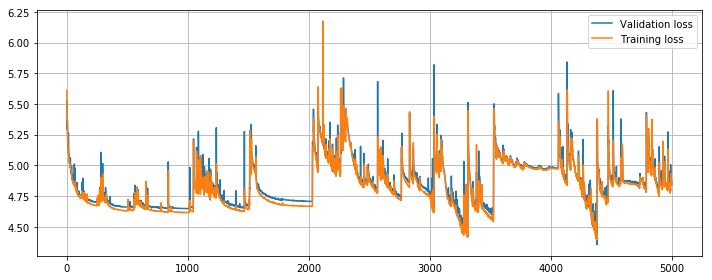

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,4))
plt.plot(autoencoder.history.history['val_loss'], label='Validation loss')
plt.plot(autoencoder.history.history['loss'], label='Training loss')
plt.legend()
plt.grid()
plt.tight_layout()

In [17]:
autoencoder.load_weights(weight_path)

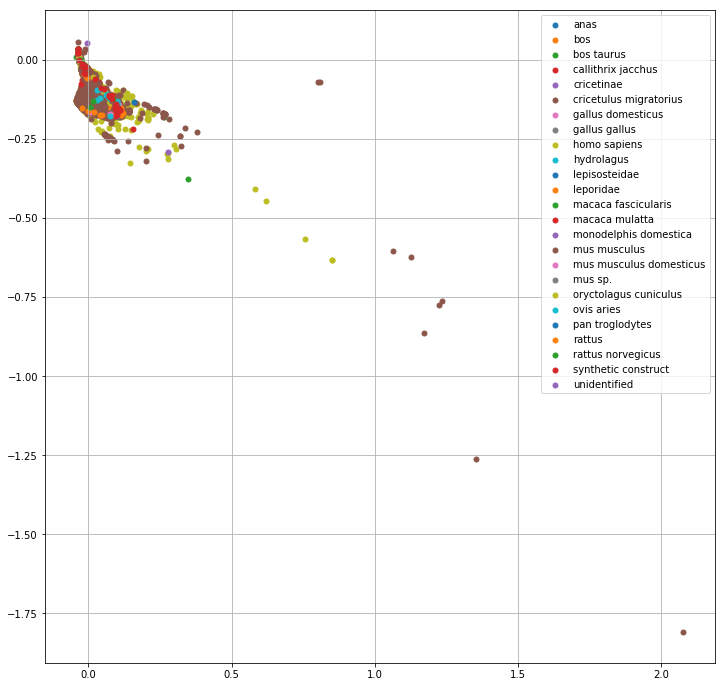

In [18]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

code = encoder.predict([VL_encoded, VH_encoded])

le = LabelEncoder().fit(animals_mask)
labels = le.transform(animals_mask)

unique_labels = np.unique(labels)
len(unique_labels)

c=sns.color_palette(n_colors=25)

f,ax = plt.subplots(figsize=(12,12))
for x in range(unique_labels.size):
    mask_labels = labels == unique_labels[x]
    ax.scatter(code[mask_labels,0], code[mask_labels,1], marker='.', c=c[x],label=le.classes_[x], s=100)
ax.legend()
leg = ax.get_legend()
for i, x in enumerate(leg.legendHandles):
    x.set_color(c[i])
ax.grid()

In [19]:
from abpytools import FabCollection, ChainCollection
import pandas as pd

combinations = pd.read_csv('/home/gil/PhD/UCB/precollection/random_pairs.txt', index_col=0, delimiter=', ')

heavy_chains = ChainCollection.load_from_json(path='/home/gil/PhD/UCB/CombinationData/AbFiles/heavy_chains.json')
light_chains = ChainCollection.load_from_json(path='/home/gil/PhD/UCB/CombinationData/AbFiles/light_chains.json')

heavy_chains_list=[]
light_chains_list=[]

for heavy, light in  combinations['Random Pairs'].str.split('-'):
    heavy_chains_list.append(heavy_chains.get_object(heavy))
    light_chains_list.append(light_chains.get_object(light))    
    
fab_collection = FabCollection(None, heavy_chains_list, light_chains_list,
                               names=['P' + str(x) for x in combinations.index.tolist()])

data = pd.read_csv('/home/gil/PhD/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

VL_data = [''.join(x).replace('-','') for x in fab_collection.numbering_table()['Light'].values]
VH_data = [''.join(x).replace('-','') for x in fab_collection.numbering_table()['Heavy'].values]

VH_data_encoded = AminoAcidEncoder(max_length=VH_LENGTH).transform(VH_data)
VL_data_encoded = AminoAcidEncoder(max_length=VL_LENGTH).transform(VL_data)

code_1 = encoder.predict([VL_data_encoded, VH_data_encoded])

latent_data = pd.DataFrame(code_1, columns=[f"Latent{x}" for x in range(1, 51)], index=fab_collection.names)

data = pd.read_csv('/home/gil/PhD/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

data.dropna(axis=0, inplace=True, subset=[data.columns[0]])

data = data.join(latent_data)

data.head()

Loading in antibody objects


/home/gil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list


,Tm D - Mean,Tm D - Std. Error,Tm2 - Mean,Tm2 - Std. Error,Latent1,Latent2,Latent3,Latent4,Latent5,Latent6,...,Latent41,Latent42,Latent43,Latent44,Latent45,Latent46,Latent47,Latent48,Latent49,Latent50
P2,64.473820,0.000000,NaN,NaN,-0.036958,0.034972,-0.100725,-0.038604,-0.050839,0.056860,...,-0.079976,-0.011134,0.062829,0.039766,0.065934,0.005641,-0.087677,-0.232456,-0.061823,0.002030
P3,73.982970,0.130358,NaN,NaN,-0.036102,0.025797,-0.093849,-0.031512,-0.051021,0.056873,...,-0.070766,-0.015038,0.055648,0.031941,0.049530,0.000879,-0.095059,-0.215754,-0.058983,0.006552
P4,64.326010,0.060344,NaN,NaN,0.053319,-0.090649,-0.072106,-0.034659,-0.077778,0.062256,...,-0.041445,0.000891,0.019565,-0.002477,-0.020454,-0.022991,-0.090388,-0.120711,-0.109693,0.008423
P6,74.192370,0.036953,NaN,NaN,0.098643,-0.165019,-0.064401,-0.022163,-0.095146,0.063259,...,0.014158,-0.000316,-0.014319,0.019736,-0.005934,-0.055245,-0.115744,-0.100963,-0.124833,0.040666
P9,72.899025,0.085337,NaN,NaN,0.113132,-0.158423,-0.078925,-0.041143,-0.092749,0.063864,...,-0.001281,-0.006561,-0.014965,0.009145,-0.006866,-0.058204,-0.107987,-0.088945,-0.137545,0.032512


In [25]:
X = data[[x for x in data.columns if 'Latent' in x]].as_matrix()

/home/gil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [26]:
norm_variance = [np.var(X[:, x] / abs(np.mean(X[:,x]))) for x in range(X.shape[1])]

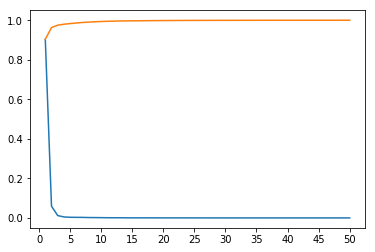

In [27]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=11))

ax.plot(range(1, 51), [norm_variance[x]/sum(norm_variance) for x in np.argsort(norm_variance)[::-1]])
ax.plot(range(1, 51), np.cumsum([norm_variance[x]/sum(norm_variance) for x in np.argsort(norm_variance)[::-1]]))

In [28]:
X=X[:, np.argsort(norm_variance)[::-1]][:, :5]

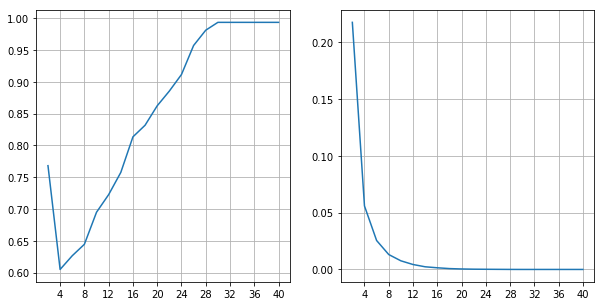

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=11))
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=11))

s_scores = []
i_scores = []
for k in range(2, 41, 2):
    kmeans = KMeans(n_clusters=k, random_state=0)
    s_scores.append(silhouette_score(X, kmeans.fit_predict(X)))
    i_scores.append(kmeans.inertia_)
ax[0].plot(range(2, 41, 2), s_scores)
ax[1].plot(range(2, 41, 2), i_scores)
ax[0].grid()
ax[1].grid()

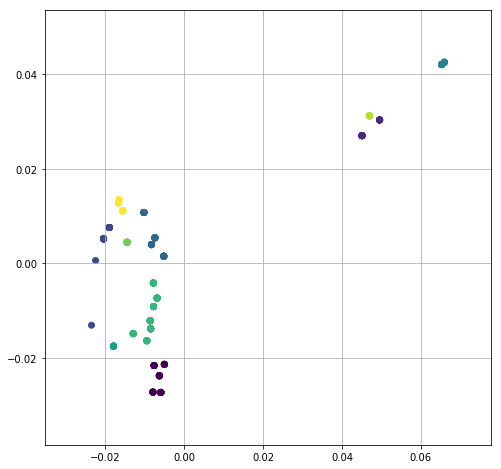

In [31]:
N_CLUSTERS = 10

kmeans = KMeans(N_CLUSTERS, random_state=0)
kmeans.fit(X)
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=kmeans.predict(X))
plt.grid()

/home/gil/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


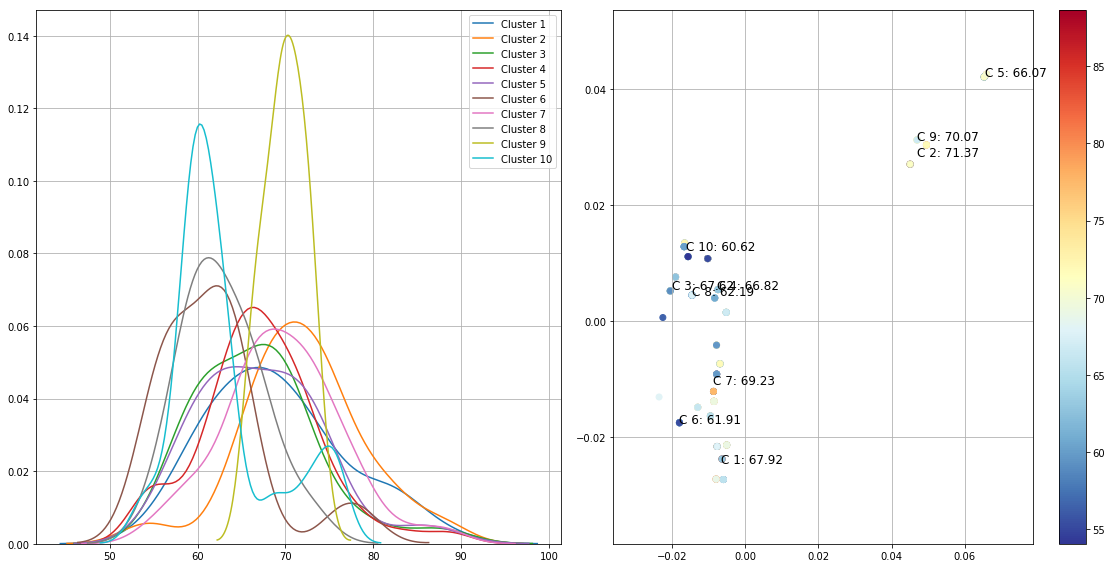

In [33]:
f, ax = plt.subplots(1,2,figsize=(16,8))
kmeans_labels = kmeans.predict(X) 
tms = ax[1].scatter(X[:,0], X[:,1], c=data['Tm D - Mean'].values, cmap='RdYlBu_r')
for x in range(N_CLUSTERS):
    ax[1].text(kmeans.cluster_centers_[x][0], kmeans.cluster_centers_[x][1],
               'C {}: {:.2f}'.format(x+1, np.median(data.values[kmeans_labels==x, 0])), fontsize=12)
cbar = f.colorbar(tms)
ax[1].grid()
for x in range(N_CLUSTERS):
    sns.distplot(data.values[kmeans_labels==x, 0], ax=ax[0], hist=False, label='Cluster {}'.format(x+1))
ax[0].legend()
ax[0].grid()
#     print(data.values[kmeans_labels==x, 0].mean(), data.values[kmeans_labels==x, 0].std())
plt.tight_layout()